# **Soil Erosion: Land-Use-Land-Cover Prediction for province Imbabura-Ecuador**

This notebook shows the steps towards constructing a machine learning pipeline for predicting the land use and land cover for the region of Imbabura of Republic of Ecuador. We use satellite images obtained by ESA’s Sentinel-2 with use [SentinelHUb](https://apps.sentinel-hub.com/) to train a model and use it for prediction. We use Google Colab with a TPU hosted runtime. The research will lead you through the whole process of creating the pipeline, with details provided at each step.

## **Before you start**

### **Requirements**

In order to run the example you’ll need a Sentinel Hub account. If you do not have one yet, you can create a free trial account at **Sentinel Hub webpage**. If you are a researcher you can even apply for a free non-commercial account at ESA OSEO page.

Once you have the account set up, please configure the [sentinelhub](https://services.sentinel-hub.com/) package’s configuration file following the [configuration instructions](https://sentinelhub-py.readthedocs.io/en/latest/configure.html). For Processing API request you need to obtain and set your ***oauth*** client id and secret.

# **Create EOPatch and fill it with L1C and derived data Imbabura-AOI**

Now is time to create an `EOPatch` for each out of 195 tiles of the AOI. The `EOPatch` is created by filling it with Sentinel-2 data using Sentinel Hub services. We will add the following data to each `EOPatch`:
* L1C RGB (bands B04, B03, and B02)
* SentinelHub's cloud probability map and cloud mask

Using the above information we can then also count how many times in a time series a pixel is valid or not from the cloud mask.

---
# **Overview**

An `EOPatch` is created and manipulated using `EOTasks` chained in an `EOWorkflow`. In this studio the final workflow is a sequence of the following tasks:

**Part 1:**
1. Define the Area-of-Interest (AOI):
    . Obtain the outline of Slovenia (provided)
    . Split into manageable smaller tiles
    . Select a small 5x5 area for classification
1. Create `EOPatch` by filling it with RGB L1C data, together with cloud masks and cloud probabilities from Sentinel-Hub (s2cloudless)
2. Validate pixels using the cloud mask
3. Count number of valid observations per pixel using valid data mask
4. Export valid pixel count to tiff file
5. Save EOPatch to disk

**Part 2:**
1. Prepare the training data
  . Remove too cloudy scenes
  . Perform temporal interpolation (filling gaps and resampling to the same dates)
  . Apply erosion
  . Random spatial sampling of the EOPatches
  . Split patches for training/validation
2. Construct and train the ML model
Make the prediction for each patch
3. Validate the model
4. Visualise the results

In [ ]:
# To see which GPU you have been assigned
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

/bin/bash: line 1: nvidia-smi: command not found


In [ ]:
!pip install aenum

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 137.6/137.6 kB 2.9 MB/s eta 0:00:00


In [ ]:
!pip install sentinelhub

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 245.1/245.1 kB 3.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.4/49.4 kB 4.9 MB/s eta 0:00:00
  Created wheel for utm: filename=utm-0.7.0-py3-none-any.whl size=6085 sha256=1d8bb690d030561547f5176cbf08b4f91c5f2354b9344fe10b4b077df02ec63e
  Stored in directory: /root/.cache/pip/wheels/2f/a1/c8/543df0e8f5e824c3e92a432e32deb9cd89ae686095ee8cfcbe
Successfully built utm


In [ ]:
!pip install eo-learn.core

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 147.6/147.6 kB 2.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 135.8/135.8 kB 14.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 135.3/135.3 kB 15.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.3/21.3 MB 10.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.3/11.3 MB 92.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.8/79.8 kB 8.9 MB/s eta 0:00:00


In [ ]:
!pip install eo-learn

In [ ]:
!pip install eo-learn.io

In [ ]:
!pip install eo-learn.mask

In [ ]:
# Firstly, some necessary imports

# Jupyter notebook related
%reload_ext autoreload
%autoreload 2
%matplotlib inline

import datetime
import itertools

# Built-in modules
import os

# Basics of Python data handling and visualization
import numpy as np
from aenum import MultiValueEnum

np.random.seed(42)
import geopandas as gpd
import joblib

# Machine learning
import lightgbm as lgb
import matplotlib.pyplot as plt
from matplotlib.colors import BoundaryNorm, ListedColormap
from shapely.geometry import Polygon
from sklearn import metrics, preprocessing
from tqdm.auto import tqdm

from sentinelhub import DataCollection, UtmZoneSplitter

# Imports from eo-learn and sentinelhub-py
from eolearn.core import (
    EOExecutor,
    EOPatch,
    EOTask,
    EOWorkflow,
    FeatureType,
    LoadTask,
    MergeFeatureTask,
    OverwritePermission,
    SaveTask,
    linearly_connect_tasks,
    EONode,
    OutputTask,
)
from eolearn.features import NormalizedDifferenceIndexTask, SimpleFilterTask
from eolearn.features.extra.interpolation import LinearInterpolationTask
from eolearn.geometry import ErosionTask, VectorToRasterTask
from eolearn.io import ExportToTiffTask, SentinelHubInputTask, VectorImportTask
from eolearn.ml_tools import FractionSamplingTask

/usr/local/lib/python3.10/dist-packages/eolearn/__init__.py:12: UserWarning: You are currently using an outdated installation of `eo-learn` for submodules ['core', 'io', 'mask']. You can find instructions on how to install `eo-learn` correctly at https://github.com/sentinel-hub/eo-learn/issues/733.
  warnings.warn(


In [ ]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

In [ ]:
import logging

logging.getLogger("requests").setLevel(logging.WARNING)
logging.getLogger("urllib3").setLevel(logging.WARNING)

In [ ]:
import pickle

In [ ]:
import os

In [ ]:
# Cloud authentication.
from google.colab import auth, drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
PACKAGE_PATH = '/content/drive/MyDrive/AI_LU_LC_Imbabura'
os.chdir (PACKAGE_PATH)

In [ ]:
!pwd

/content/drive/MyDrive/AI_LU_LC_Imbabura


In [ ]:
# Folder where data for running the notebook is stored
DATA_FOLDER = os.path.join(PACKAGE_PATH,  "example_data")
# Locations for save the splitter to pickle file for later use
TILE_FOLDER = os.path.join(PACKAGE_PATH, "tile-def")
# Locations for save the figs
FIGS_FOLDER = os.path.join(PACKAGE_PATH, "figs")
# Locations for save epopatches
EOPATCH_FOLDER = os.path.join(PACKAGE_PATH, "eopatches")
EOPATCH_SAMPLES_FOLDER = os.path.join(PACKAGE_PATH, "eopatches_sampled")
# Locations for result
RESULTS_FOLDER = os.path.join(PACKAGE_PATH, "results")

LogIn SentinelHub register

In [ ]:
from sentinelhub import SHConfig

config = SHConfig()

config

SHConfig(
  instance_id='',
  sh_client_id='',
  sh_client_secret='',
  sh_base_url='https://services.sentinel-hub.com',
  sh_auth_base_url=None,
  sh_token_url='https://services.sentinel-hub.com/oauth/token',
  geopedia_wms_url='https://service.geopedia.world',
  geopedia_rest_url='https://www.geopedia.world/rest',
  aws_access_key_id='',
  aws_secret_access_key='',
  aws_session_token='',
  aws_metadata_url='https://roda.sentinel-hub.com',
  aws_s3_l1c_bucket='sentinel-s2-l1c',
  aws_s3_l2a_bucket='sentinel-s2-l2a',
  opensearch_url='http://opensearch.sentinel-hub.com/resto/api/collections/Sentinel2',
  max_wfs_records_per_query=100,
  max_opensearch_records_per_query=500,
  max_download_attempts=4,
  download_sleep_time=5.0,
  download_timeout_seconds=120.0,
  number_of_download_processes=1,
)

In [ ]:
# Insert your credentials here in case you don't already have them in the config.toml file:
# Auth CLient Imbabura-eo-learn
SH_CLIENT_ID = "01a8d1de-a7e3-44d0-a12c-166d0e1de4bf"
SH_CLIENT_SECRET = "u9Fz2MOfiVsb5vzzgUQUVbt7iY5PlaHFF8yc4znB"
AWS_ACCESS_KEY_ID = ""
AWS_SECRET_ACCESS_KEY = ""

config = SHConfig()

if SH_CLIENT_ID and SH_CLIENT_SECRET:
    config.sh_client_id = SH_CLIENT_ID
    config.sh_client_secret = SH_CLIENT_SECRET

if not config.sh_client_id or not config.sh_client_secret:
    print("Warning! To use Sentinel Hub BYOC API, please provide the credentials (client ID and client secret).")

if AWS_ACCESS_KEY_ID and AWS_SECRET_ACCESS_KEY:
    config.aws_access_key_id = AWS_ACCESS_KEY_ID
    config.aws_secret_access_key = AWS_SECRET_ACCESS_KEY

# If you want to save the instance, deactivate
config.save("default-profile")
config

SHConfig(
  instance_id='',
  sh_client_id='********************************e4bf',
  sh_client_secret='************************************4znB',
  sh_base_url='https://services.sentinel-hub.com',
  sh_auth_base_url=None,
  sh_token_url='https://services.sentinel-hub.com/oauth/token',
  geopedia_wms_url='https://service.geopedia.world',
  geopedia_rest_url='https://www.geopedia.world/rest',
  aws_access_key_id='',
  aws_secret_access_key='',
  aws_session_token='',
  aws_metadata_url='https://roda.sentinel-hub.com',
  aws_s3_l1c_bucket='sentinel-s2-l1c',
  aws_s3_l2a_bucket='sentinel-s2-l2a',
  opensearch_url='http://opensearch.sentinel-hub.com/resto/api/collections/Sentinel2',
  max_wfs_records_per_query=100,
  max_opensearch_records_per_query=500,
  max_download_attempts=4,
  download_sleep_time=5.0,
  download_timeout_seconds=120.0,
  number_of_download_processes=1,
)

### Get BBoxSplitter with tile definitions

In [ ]:
# Load input files /content/tile-def/Imbabura_buffered_bbox_32617_17x25.pickle
#from google.colab import files
#uploaded = files.upload()

Saving Imbabura_buffered_bbox_32617_17x25.pickle to Imbabura_buffered_bbox_32617_17x25.pickle


In [ ]:
with open(os.path.join(TILE_FOLDER,"Imbabura_buffered_bbox_32617_17x25.pickle"), "rb") as fp:
    bbox_splitter = pickle.load(fp)

In [ ]:
patch_ids=len(bbox_splitter.bbox_list)
patch_ids

195

In [ ]:
id_patch=110
bbox_splitter.bbox_list[id_patch]

BBox(((796644.1505816347, 38235.17647058824), (803171.883850342, 43148.41176470588)), crs=CRS('32617'))

In [ ]:
bbox_splitter.info_list[id_patch]

{'parent_bbox': BBox(((692200.4182823192, 13669.0), (855393.7499999998, 97194.0)), crs=CRS('32617')),
 'index_x': 16,
 'index_y': 5}

### Define what makes a pixel valid

In [ ]:
bbox_list = np.array(bbox_splitter.get_bbox_list())
info_list = np.array(bbox_splitter.get_info_list())

In [ ]:
import pandas as pd
# Prepare info of selected EOPatches
geometry = [Polygon(bbox.get_polygon()) for bbox in bbox_list]
#idxs = [info["index"] for info in info_list]
idxs_x = [info["index_x"] for info in info_list]
idxs_y = [info["index_y"] for info in info_list]

common_crs = bbox_splitter.bbox_list[0].crs
df = pd.DataFrame({"index_x": idxs_x, "index_y": idxs_y})
bbox_gdf = gpd.GeoDataFrame(df, crs=common_crs.pyproj_crs(), geometry=geometry)

In [ ]:
# select a 5x5 area (id of center patch)
ID = 110

# Obtain surrounding 5x5 patches
patch_ids = []
for idx, info in enumerate(info_list):
    if abs(info["index_x"] - info_list[ID]["index_x"]) <= 2 and abs(info["index_y"] - info_list[ID]["index_y"]) <= 2:
        patch_ids.append(idx)

# Check if final size is 5x5
if len(patch_ids) != 5 * 5:
    print("Warning! Use a different central patch ID, this one is on the border.")

# Change the order of the patches (useful for plotting)
patch_ids = np.transpose(np.fliplr(np.array(patch_ids).reshape(5, 5))).ravel()

# Save to shapefile
shapefile_name = "grid_imbabura_5km.gpkg"
bbox_gdf.to_file(os.path.join(RESULTS_FOLDER, shapefile_name), driver="GPKG")

# eo-learn Workflow to create patches

Now it's time to create EOPatches and fill them with Sentinel-2 data using Sentinel Hub services. We will add the following data to each EOPatch:

L1C custom list of bands [B02, B03, B04, B08, B11, B12], which corresponds to [B, G, R, NIR, SWIR1, SWIR2] wavelengths.

SentinelHub's cloud mask

1.   Additionally, we will add:
2.   Calculated NDVI, NDWI, and NDBI information


A mask of validity, based on acquired data from Sentinel and cloud coverage. Valid pixel is if:

*   IS_DATA == True
*   CLOUD_MASK == 0 (1 indicates cloudy pixels and 255 indicates NO_DATA)

An EOPatch is created and manipulated using EOTasks, which are chained in an EOWorkflow. In this example the final workflow is executed on all patches, which are saved to the specified directory.

### Define custom tasks

In [ ]:
class SentinelHubValidDataTask(EOTask):
    """
    Combine Sen2Cor's classification map with `IS_DATA` to define a `VALID_DATA_SH` mask
    The SentinelHub's cloud mask is asumed to be found in eopatch.mask['CLM']
    """

    def __init__(self, output_feature):
        self.output_feature = output_feature

    def execute(self, eopatch):
        eopatch[self.output_feature] = eopatch.mask["IS_DATA"].astype(bool) & (~eopatch.mask["CLM"].astype(bool))
        return eopatch


class AddValidCountTask(EOTask):
    """
    The task counts number of valid observations in time-series and stores the results in the timeless mask.
    """

    def __init__(self, count_what, feature_name):
        self.what = count_what
        self.name = feature_name

    def execute(self, eopatch):
        eopatch[FeatureType.MASK_TIMELESS, self.name] = np.count_nonzero(eopatch.mask[self.what], axis=0)
        return eopatch

## Initialise tasks

In [ ]:
# BAND DATA
# Add a request for S2 bands.
# Here we also do a simple filter of cloudy scenes (on tile level).
# The s2cloudless masks and probabilities are requested via additional data.
band_names = ["B02", "B03", "B04", "B08", "B11", "B12"]
add_data = SentinelHubInputTask(
    bands_feature=(FeatureType.DATA, "BANDS"),
    bands=band_names,
    resolution=10,
    maxcc=0.8,
    time_difference=datetime.timedelta(minutes=120),
    data_collection=DataCollection.SENTINEL2_L1C,
    additional_data=[(FeatureType.MASK, "dataMask", "IS_DATA"), (FeatureType.MASK, "CLM"), (FeatureType.DATA, "CLP")],
    max_threads=5,
)


# CALCULATING NEW FEATURES
# NDVI: (B08 - B04)/(B08 + B04)
# NDWI: (B03 - B08)/(B03 + B08)
# NDBI: (B11 - B08)/(B11 + B08)
ndvi = NormalizedDifferenceIndexTask(
    (FeatureType.DATA, "BANDS"), (FeatureType.DATA, "NDVI"), [band_names.index("B08"), band_names.index("B04")]
)
ndwi = NormalizedDifferenceIndexTask(
    (FeatureType.DATA, "BANDS"), (FeatureType.DATA, "NDWI"), [band_names.index("B03"), band_names.index("B08")]
)
ndbi = NormalizedDifferenceIndexTask(
    (FeatureType.DATA, "BANDS"), (FeatureType.DATA, "NDBI"), [band_names.index("B11"), band_names.index("B08")]
)


# VALIDITY MASK
# Validate pixels using SentinelHub's cloud detection mask and region of acquisition
add_sh_validmask = SentinelHubValidDataTask((FeatureType.MASK, "IS_VALID"))

# COUNTING VALID PIXELS
# Count the number of valid observations per pixel using valid data mask
add_valid_count = AddValidCountTask("IS_VALID", "VALID_COUNT")

# SAVING TO OUTPUT (if needed)
save = SaveTask(EOPATCH_FOLDER, overwrite_permission=OverwritePermission.OVERWRITE_FEATURES)

Reference map task
For this example, a subset of the country-wide reference for land-use-land-cover is provided. It is available in the form of a geopackage, which contains polygons and their corresponding labels. The labels represent the following 10 classes:

*   lulcid = 0, name = no data
*   lulcid = 1, name = cultivated land
*   lulcid = 2, name = forest
*   lulcid = 3, name = grassland
*   lulcid = 4, name = shrubland
*   lulcid = 5, name = water
*   lulcid = 6, name = wetlands
*   lulcid = 7, name = tundra
*   lulcid = 8, name = artificial surface
*   lulcid = 9, name = bareland
*   lulcid = 10, name = snow and ice

We have defined a land cover enum class for ease of use below.

In [ ]:
class LULC(MultiValueEnum):
    """Enum class containing basic LULC types"""

    NO_DATA = "No Data", 0, "#ffffff"
    CULTIVATED_LAND = "Cultivated Land", 1, "#ffff00"
    FOREST = "Forest", 2, "#054907"
    GRASSLAND = "Grassland", 3, "#ffa500"
    SHRUBLAND = "Schrubland", 4, "#806000"
    WATER = "Water", 5, "#069af3"
    WETLAND = "Wetland", 6, "#95d0fc"
    TUNDRA = "Tundra", 7, "#967bb6"
    ARTIFICIAL_SURFACE = "Artificial Surface", 8, "#dc143c"
    BARELAND = "Bareland", 9, "#a6a6a6"
    SNOW_AND_ICE = "Snow and Ice", 10, "#000000"

    @property
    def id(self):
        return self.values[1]

    @property
    def color(self):
        return self.values[2]


# Reference colormap things
lulc_cmap = ListedColormap([x.color for x in LULC], name="lulc_cmap")
lulc_norm = BoundaryNorm([x - 0.5 for x in range(len(LULC) + 1)], lulc_cmap.N)

The main point of this task is to create a raster mask from the vector polygons and add it to the eopatch. With this procedure, any kind of a labeled shapefile can be transformed into a raster reference map. This result is achieved with the existing task `VectorToRaster` from the `eolearn.geometry` package. All polygons belonging to the each of the classes are separately burned to the raster mask.

Land use data are public in Imbabura, you can use the provided partial dataset for this example, or download the full dataset (if you want to upscale the project) [from our bucket](http://eo-learn.sentinel-hub.com/). The datasets have already been pre-processed for the purposes of the example.

In [ ]:
#Load input file Imbabura_17n18n2022010120221231lulc_class_reference.gpkg
#uploaded = files.upload()

In [ ]:
land_use_ref_path = os.path.join(DATA_FOLDER, "Imbabura_17n18n2022010120221231lulc_class_reference.gpkg")

In [ ]:
vector_feature = FeatureType.VECTOR_TIMELESS, "LULC_REFERENCE"

vector_import_task = VectorImportTask(vector_feature, land_use_ref_path)

rasterization_task = VectorToRasterTask(
    vector_feature,
    (FeatureType.MASK_TIMELESS, "LULC"),
    values_column="lulcid",
    raster_shape=(FeatureType.MASK, "IS_DATA"),
    raster_dtype=np.uint8,
)

## Define workflow

All the tasks that were defined so far create and fill the EOPatches. The tasks need to be put in some order and executed one by one. This can be achieved by manually executing the tasks, or more conveniently, defining an EOWorkflow which does this for you.

The following workflow is created and executed:

Create EOPatches with band and cloud data
Calculate and add NDVI, NDWI, NORM
Add mask of valid pixels
Add scalar feature representing the count of valid pixels
Save eopatches
An EOWorkflow can be linear or more complex, but it should be acyclic. Here we will use the linear case of the EOWorkflow, available as LinearWorkflow

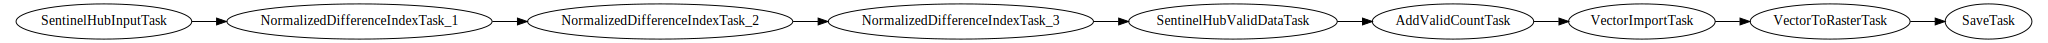

In [ ]:
# Define the workflow
workflow_nodes = linearly_connect_tasks(
    add_data, ndvi, ndwi, ndbi, add_sh_validmask, add_valid_count, vector_import_task, rasterization_task, save
)
workflow = EOWorkflow(workflow_nodes)

# Let's visualize it
workflow.dependency_graph()

In [ ]:
%%time

# Time interval for the SH request
time_interval = ["2022-01-01", "2022-12-31"]

# Define additional parameters of the workflow
input_node = workflow_nodes[0]
save_node = workflow_nodes[-1]
execution_args = []
for idx, bbox in enumerate(bbox_list[patch_ids]):
    execution_args.append(
        {
            input_node: {"bbox": bbox, "time_interval": time_interval},
            save_node: {"eopatch_folder": f"eopatch_{idx}"},
        }
    )

# Execute the workflow
executor = EOExecutor(workflow, execution_args, save_logs=True)
executor.run(workers=4)

executor.make_report()

failed_ids = executor.get_failed_executions()
if failed_ids:
    raise RuntimeError(
        f"Execution failed EOPatches with IDs:\n{failed_ids}\n"
        f"For more info check report at {executor.get_report_path()}"
    )

DEBUG:eolearn.core.eoworkflow:Computing SentinelHubInputTask(*[], **{'bbox': BBox(((783588.6840442204, 48061.647058823524), (790116.4173129275, 52974.882352941175)), crs=CRS('32617')), 'time_interval': ['2022-01-01', '2022-12-31']})


  0%|          | 0/25 [00:00<?, ?it/s]

Se han truncado las últimas 5000 líneas del flujo de salida.
DEBUG:fiona.ogrext:Next index: 568
DEBUG:fiona.ogrext:Next index: 569
DEBUG:fiona.ogrext:Next index: 570
DEBUG:fiona.ogrext:Next index: 571
DEBUG:fiona.ogrext:Next index: 572
DEBUG:fiona.ogrext:Next index: 573
DEBUG:fiona.ogrext:Next index: 574
DEBUG:fiona.ogrext:Next index: 575
DEBUG:fiona.ogrext:Next index: 576
DEBUG:fiona.ogrext:Next index: 577
DEBUG:fiona.ogrext:Next index: 578
DEBUG:fiona.ogrext:Next index: 579
DEBUG:fiona.ogrext:Next index: 580
DEBUG:fiona.ogrext:Next index: 581
DEBUG:fiona.ogrext:Next index: 582
DEBUG:fiona.ogrext:Next index: 583
DEBUG:fiona.ogrext:Next index: 584
DEBUG:fiona.ogrext:Next index: 585
DEBUG:fiona.ogrext:Next index: 586
DEBUG:fiona.ogrext:Next index: 587
DEBUG:fiona.ogrext:Next index: 588
DEBUG:fiona.ogrext:Next index: 589
DEBUG:fiona.ogrext:Next index: 590
DEBUG:fiona.ogrext:Next index: 591
DEBUG:fiona.ogrext:Next index: 592
DEBUG:fiona.ogrext:Next index: 593
DEBUG:fiona.ogrext:Next index

CPU times: user 38.6 s, sys: 7.66 s, total: 46.3 s
Wall time: 16min 58s


#### Check the content of the EOPatch

In [ ]:
EOPATCH_O = os.path.join(EOPATCH_FOLDER, "eopatch_0")

In [ ]:
eopatch=EOPatch.load(EOPATCH_O)

In [ ]:
patch = eopatch
eopatch

EOPatch(
  bbox=BBox(((783588.6840442204, 48061.647058823524), (790116.4173129275, 52974.882352941175)), crs=CRS('32617'))
  timestamps=[2022-01-11 15:43:09, ...]<length=43>
  mask_timeless={
    LULC: numpy.ndarray(shape=(491, 653, 1), dtype=uint8)
    VALID_COUNT: numpy.ndarray(shape=(491, 653, 1), dtype=int64)
  }
  mask={
    CLM: numpy.ndarray(shape=(43, 491, 653, 1), dtype=uint8)
    IS_DATA: numpy.ndarray(shape=(43, 491, 653, 1), dtype=bool)
    IS_VALID: numpy.ndarray(shape=(43, 491, 653, 1), dtype=bool)
  }
  vector_timeless={
    LULC_REFERENCE: geopandas.GeoDataFrame(columns=['DN', 'layer', 'path', 'lulcid', 'lulcname', 'geometry'], length=173, crs=EPSG:32617)
  }
  data={
    BANDS: numpy.ndarray(shape=(43, 491, 653, 6), dtype=float32)
    CLP: numpy.ndarray(shape=(43, 491, 653, 1), dtype=uint8)
    NDBI: numpy.ndarray(shape=(43, 491, 653, 1), dtype=float32)
    NDVI: numpy.ndarray(shape=(43, 491, 653, 1), dtype=float32)
    NDWI: numpy.ndarray(shape=(43, 491, 653, 1), dtyp

In [ ]:
patch.timestamp

<ipython-input-35-627632d339b5>:1: EODeprecationWarning: The attribute `timestamp` is deprecated, use `timestamps` instead.
  patch.timestamp


[datetime.datetime(2022, 1, 11, 15, 43, 9),
 datetime.datetime(2022, 1, 26, 15, 43, 1),
 datetime.datetime(2022, 2, 10, 15, 43, 6),
 datetime.datetime(2022, 3, 7, 15, 43, 5),
 datetime.datetime(2022, 3, 17, 15, 43, 5),
 datetime.datetime(2022, 4, 1, 15, 43, 9),
 datetime.datetime(2022, 4, 6, 15, 43, 4),
 datetime.datetime(2022, 4, 11, 15, 43, 9),
 datetime.datetime(2022, 4, 21, 15, 43, 12),
 datetime.datetime(2022, 4, 26, 15, 43, 1),
 datetime.datetime(2022, 5, 1, 15, 43, 12),
 datetime.datetime(2022, 5, 6, 15, 43, 3),
 datetime.datetime(2022, 5, 11, 15, 43, 11),
 datetime.datetime(2022, 5, 21, 15, 43, 14),
 datetime.datetime(2022, 5, 31, 15, 43, 15),
 datetime.datetime(2022, 6, 5, 15, 43, 8),
 datetime.datetime(2022, 6, 15, 15, 43, 11),
 datetime.datetime(2022, 6, 25, 15, 43, 12),
 datetime.datetime(2022, 7, 5, 15, 43, 12),
 datetime.datetime(2022, 7, 10, 15, 43, 20),
 datetime.datetime(2022, 7, 15, 15, 43, 12),
 datetime.datetime(2022, 7, 20, 15, 43, 19),
 datetime.datetime(2022, 7, 

Due to the maxcc filtering, not all patches have the same amount of timestamps.

Let's select a date and draw the closest timestamp for each eopatch.

In [ ]:
# Draw the RGB images
fig, axs = plt.subplots(nrows=5, ncols=5, figsize=(20, 20))

date = datetime.datetime(2020, 7, 1)

for i in tqdm(range(len(patch_ids))):
    eopatch_path = os.path.join(EOPATCH_FOLDER, f"eopatch_{i}")
    eopatch = EOPatch.load(eopatch_path, lazy_loading=True)

    dates = np.array([timestamp.replace(tzinfo=None) for timestamp in eopatch.timestamps])
    closest_date_id = np.argsort(abs(date - dates))[0]

    ax = axs[i // 5][i % 5]
    ax.imshow(np.clip(eopatch.data["BANDS"][closest_date_id][..., [2, 1, 0]] * 3.5, 0, 1))
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_aspect("auto")
    del eopatch

fig.subplots_adjust(wspace=0, hspace=0)
name_file_fig = os.path.join(FIGS_FOLDER, f"Imbabura-RGB-before-training.png")
fig.savefig(name_file_fig, bbox_inches="tight")

Output hidden; open in https://colab.research.google.com to view.

## Visualize the reference map

  0%|          | 0/25 [00:00<?, ?it/s]

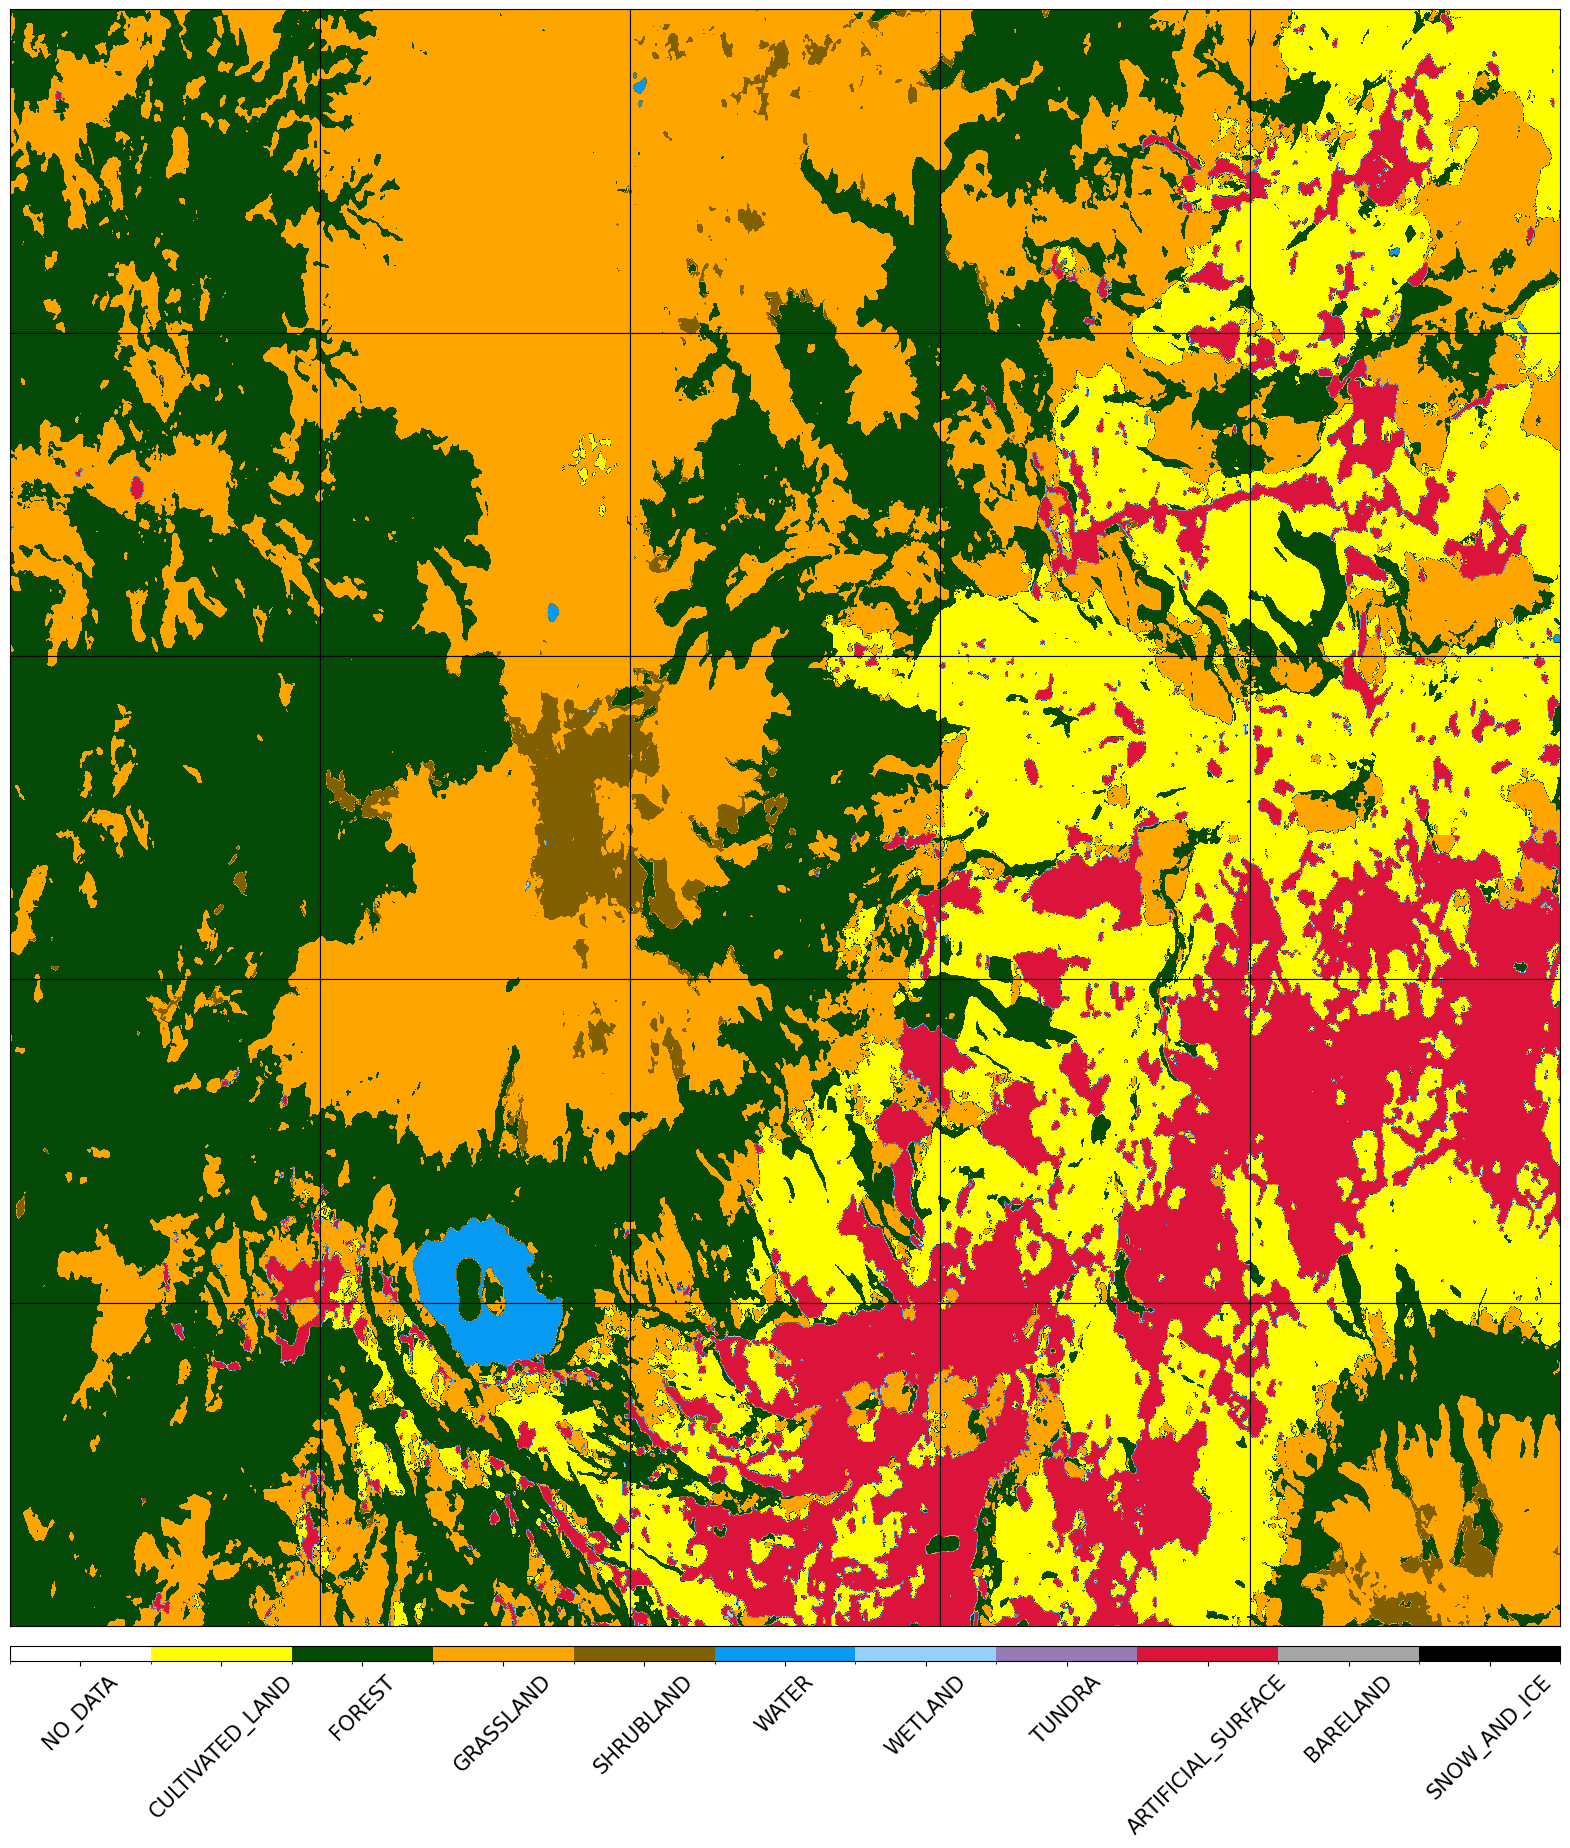

In [ ]:
fig, axs = plt.subplots(nrows=5, ncols=5, figsize=(20, 25))

for i in tqdm(range(len(patch_ids))):
    eopatch_path = os.path.join(EOPATCH_FOLDER, f"eopatch_{i}")
    eopatch = EOPatch.load(eopatch_path, lazy_loading=True)

    ax = axs[i // 5][i % 5]
    im = ax.imshow(eopatch.mask_timeless["LULC"].squeeze(), cmap=lulc_cmap, norm=lulc_norm)

    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_aspect("auto")
    del eopatch

fig.subplots_adjust(wspace=0, hspace=0)

cb = fig.colorbar(im, ax=axs.ravel().tolist(), orientation="horizontal", pad=0.01, aspect=100)
cb.ax.tick_params(labelsize=20)
cb.set_ticks([entry.id for entry in LULC])
cb.ax.set_xticklabels([entry.name for entry in LULC], rotation=45, fontsize=15)
plt.show();

name_file_fig = os.path.join(FIGS_FOLDER, f"Imbabura-LULC-before-training.png")
fig.savefig(name_file_fig, bbox_inches="tight")

#### Plot RGB, SCL, and Cloud probability, and number of valid observations

In [ ]:
def plot_frame(patch, idx, scale=1, save_fig=True):
    fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(20, 20))

    axs[0, 0].imshow(scale * patch.data["NDVI"][idx])
    axs[0, 0].set_title(f"RGB {patch.timestamp[idx]}")
    axs[0, 1].imshow(patch.mask["IS_VALID"][idx, ..., 0], vmin=0, vmax=1)
    axs[0, 1].set_title(f"Valid data {patch.timestamp[idx]}")
    axs[1, 0].imshow(patch.mask["CLM"][idx, ..., 0], vmin=0, vmax=1)
    axs[1, 0].set_title(f"SentinelHub Cloud Mask {patch.timestamp[idx]}")
    divider = make_axes_locatable(axs[1, 1])
    cax = divider.append_axes("right", size="5%", pad=0.05)
    im = axs[1, 1].imshow(patch.data["CLP"][idx, ..., 0] / 255.0, cmap=plt.cm.inferno, vmin=0.0, vmax=1.0)
    fig.colorbar(im, cax=cax, orientation="vertical")
    axs[1, 1].imshow(patch.data["NDWI"][idx, ..., 0] / 255.0, cmap=plt.cm.inferno)
    axs[1, 1].set_title(f"SentinelHub Cloud Probability {patch.timestamp[idx]}")

    if save_fig:
        name_file_fig = os.path.join(FIGS_FOLDER, f"patch_{idx}_{patch.timestamp[idx]}.png")
        #fig.savefig(f"figs/patch_{idx}_{patch.timestamp[idx]}.png", bbox_inches="tight")
        fig.savefig(name_file_fig, bbox_inches="tight")
        fig.clf()

In [ ]:
plot_frame(patch, 0, scale=3.5)

<ipython-input-38-3c295d463ff5>:5: EODeprecationWarning: The attribute `timestamp` is deprecated, use `timestamps` instead.
  axs[0, 0].set_title(f"RGB {patch.timestamp[idx]}")
<ipython-input-38-3c295d463ff5>:7: EODeprecationWarning: The attribute `timestamp` is deprecated, use `timestamps` instead.
  axs[0, 1].set_title(f"Valid data {patch.timestamp[idx]}")
<ipython-input-38-3c295d463ff5>:9: EODeprecationWarning: The attribute `timestamp` is deprecated, use `timestamps` instead.
  axs[1, 0].set_title(f"SentinelHub Cloud Mask {patch.timestamp[idx]}")
<ipython-input-38-3c295d463ff5>:15: EODeprecationWarning: The attribute `timestamp` is deprecated, use `timestamps` instead.
  axs[1, 1].set_title(f"SentinelHub Cloud Probability {patch.timestamp[idx]}")
<ipython-input-38-3c295d463ff5>:18: EODeprecationWarning: The attribute `timestamp` is deprecated, use `timestamps` instead.
  name_file_fig = os.path.join(FIGS_FOLDER, f"patch_{idx}_{patch.timestamp[idx]}.png")


<Figure size 2000x2000 with 0 Axes>

In [ ]:
plot_frame(patch, -1)

<ipython-input-38-3c295d463ff5>:5: EODeprecationWarning: The attribute `timestamp` is deprecated, use `timestamps` instead.
  axs[0, 0].set_title(f"RGB {patch.timestamp[idx]}")
<ipython-input-38-3c295d463ff5>:7: EODeprecationWarning: The attribute `timestamp` is deprecated, use `timestamps` instead.
  axs[0, 1].set_title(f"Valid data {patch.timestamp[idx]}")
<ipython-input-38-3c295d463ff5>:9: EODeprecationWarning: The attribute `timestamp` is deprecated, use `timestamps` instead.
  axs[1, 0].set_title(f"SentinelHub Cloud Mask {patch.timestamp[idx]}")
<ipython-input-38-3c295d463ff5>:15: EODeprecationWarning: The attribute `timestamp` is deprecated, use `timestamps` instead.
  axs[1, 1].set_title(f"SentinelHub Cloud Probability {patch.timestamp[idx]}")
<ipython-input-38-3c295d463ff5>:18: EODeprecationWarning: The attribute `timestamp` is deprecated, use `timestamps` instead.
  name_file_fig = os.path.join(FIGS_FOLDER, f"patch_{idx}_{patch.timestamp[idx]}.png")


<Figure size 2000x2000 with 0 Axes>

#### Plot number of valid observations

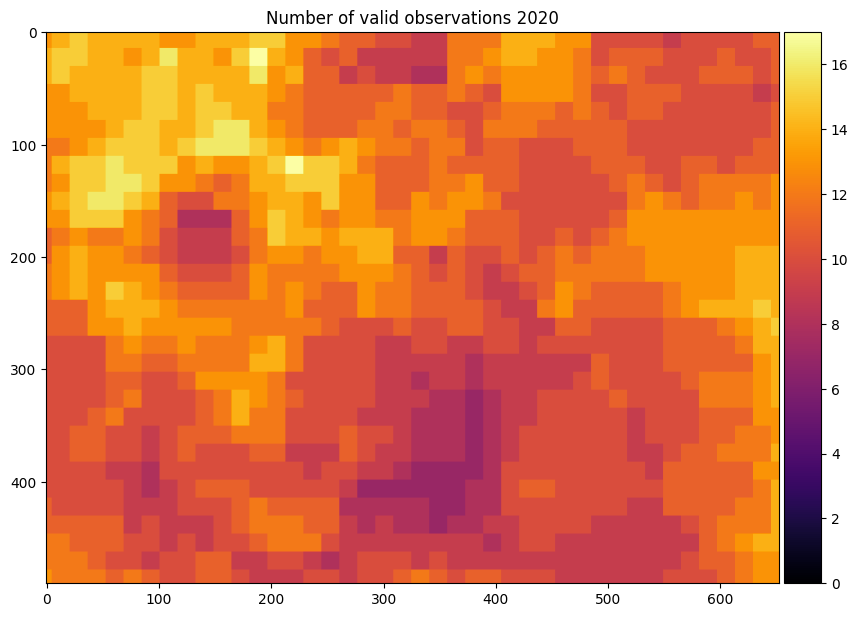

In [ ]:
fig, ax = plt.subplots(figsize=(10, 10))
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
im = ax.imshow(
    patch.mask_timeless["VALID_COUNT"][..., 0],
    cmap=plt.cm.inferno,
    vmin=0,
    vmax=np.max(patch.mask_timeless["VALID_COUNT"]),
)
ax.set_title("Number of valid observations 2020")
fig.colorbar(im, cax=cax, orientation="vertical")
name_file_fig = os.path.join(FIGS_FOLDER, f"Imbabura_Number_of_valid_observations_eopatch_0.png")
fig.savefig(name_file_fig, bbox_inches="tight")

#### Plot average cloud probability

In [ ]:
avecld = np.sum(patch.data["CLP"][..., 0], axis=(0)) / patch.data["CLP"].shape[0]
avecld /= 255.0

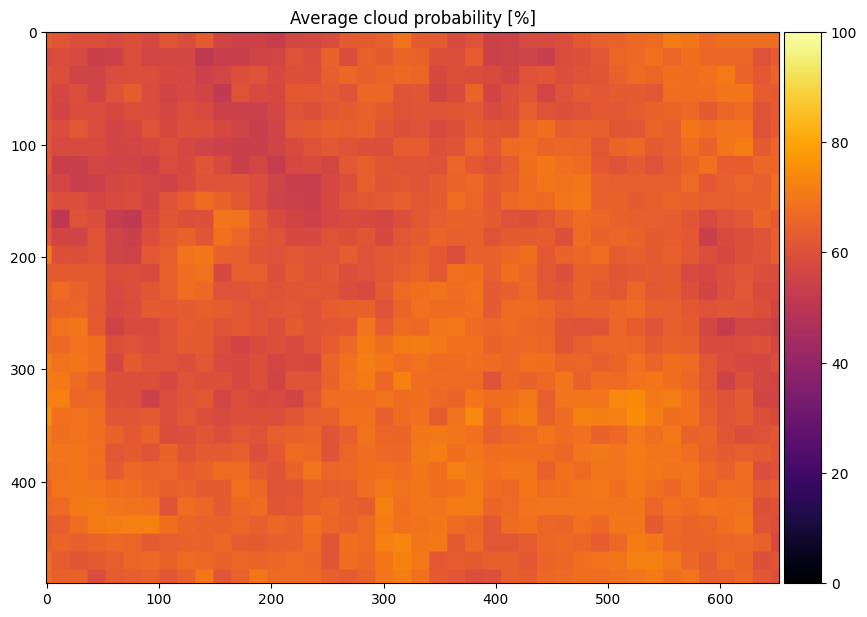

In [ ]:
fig, ax = plt.subplots(figsize=(10, 10))
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
im = ax.imshow(avecld * 100, cmap=plt.cm.inferno, vmin=0, vmax=100.0)
ax.set_title("Average cloud probability [%]")
fig.colorbar(im, cax=cax, orientation="vertical");

name_file_fig = os.path.join(FIGS_FOLDER, f"Imbabura_average_cloud_probability_eopatch_0.png")
fig.savefig(name_file_fig, bbox_inches="tight")

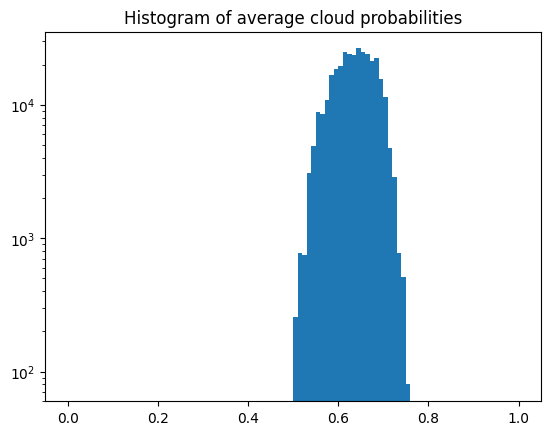

In [ ]:
plt.hist((avecld).flatten(), range=(0, 1), bins=100, log=True)
plt.title("Histogram of average cloud probabilities");

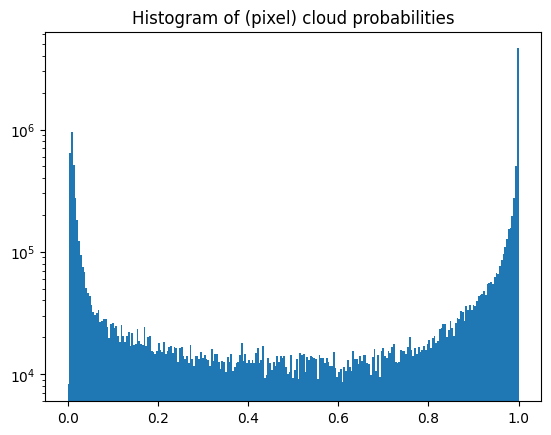

In [ ]:
plt.hist((patch.data["CLP"]).flatten() / 255.0, range=(0, 1), bins=255, log=True)
plt.title("Histogram of (pixel) cloud probabilities");

#### Plot fraction of valid pixels per frame

In [ ]:
def valid_fraction(arr):
    """
    Calculates fraction of non-zero pixels.
    """
    return np.count_nonzero(arr) / np.size(arr)

In [ ]:
valid_frac = np.apply_along_axis(
    valid_fraction, axis=1, arr=np.reshape(patch.mask["IS_VALID"], (patch.mask["IS_VALID"].shape[0], -1))
)

In [ ]:
valid_frac.shape

(43,)

<ipython-input-49-3706b03306ef>:2: EODeprecationWarning: The attribute `timestamp` is deprecated, use `timestamps` instead.
  ax.plot(patch.timestamp, valid_frac, "o-")


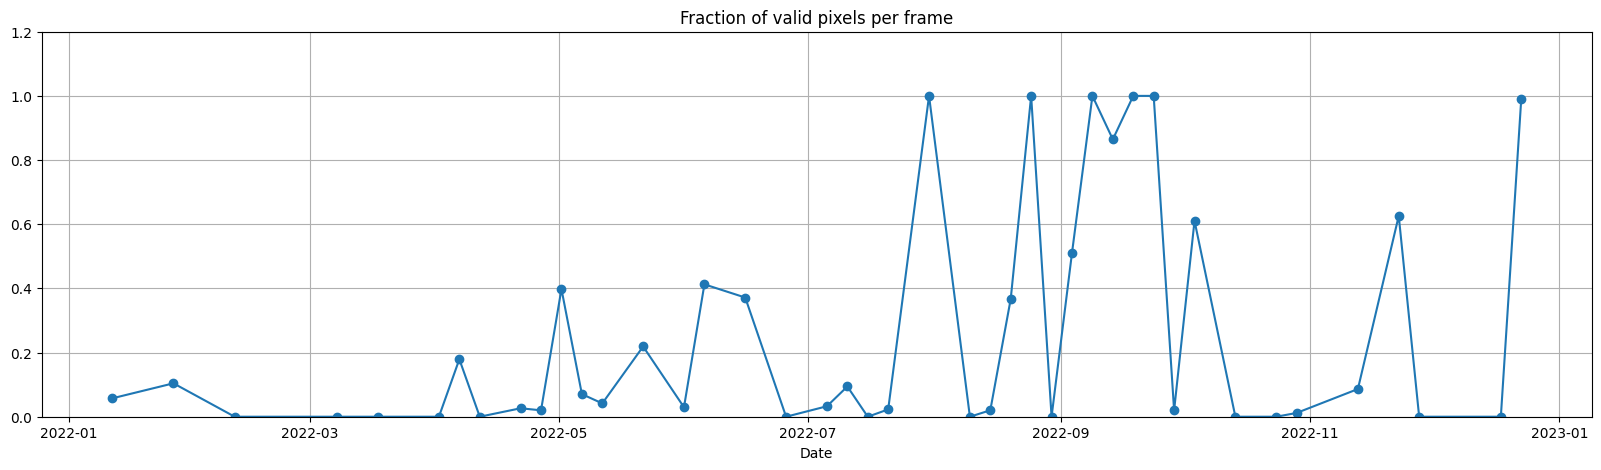

In [ ]:
fig, ax = plt.subplots(figsize=(20, 5))
ax.plot(patch.timestamp, valid_frac, "o-")
ax.set_title("Fraction of valid pixels per frame")
ax.set_xlabel("Date")
ax.set_ylim(0.0, 1.2)
ax.grid()
name_file_fig = os.path.join(FIGS_FOLDER, f"Imbabura_fraction_valid_pixels_per_frame_eopatch-0.png")
fig.savefig(name_file_fig, bbox_inches="tight")

Next step would be to run the Training and SampleTest.

# ** Part 2
# 1. Prepare the training data**
We will create a new workflow that processes the data:
1.  Remove too cloudy scenes:
    * Check the ratio of the valid data for each patch and for each time frame
    * Keep only time frames with > 80 % valid coverage (no clouds)
2.  Concatenate BAND, NDVI, NDWI, NDBI info into a single feature called FEATURES
3.  Perform temporal interpolation (filling gaps and resampling to the same dates):
    * Create a task for linear interpolation in the temporal dimension
    * Provide the cloud mask to tell the interpolating function which values to update
4.  Perform erosion:
    * This removes artefacts with a width of 1 px, and also removes the edges between polygons of different classes
5.  Random spatial sampling of the EOPatches:
    * Randomly take a subset of pixels from a patch to use in the machine learning training

6.  Split patches for training/validation:

    * Split the patches into a training and validation set

# **Define EOTasks EROSION**

In [ ]:
class ValidDataFractionPredicate:
    """Predicate that defines if a frame from EOPatch's time-series is valid or not. Frame is valid if the
    valid data fraction is above the specified threshold.
    """

    def __init__(self, threshold):
        self.threshold = threshold

    def __call__(self, array):
        coverage = np.sum(array.astype(np.uint8)) / np.prod(array.shape)
        return coverage > self.threshold

In [ ]:
# LOAD EXISTING EOPATCHES
load = LoadTask(EOPATCH_FOLDER)

# FEATURE CONCATENATION
concatenate = MergeFeatureTask({FeatureType.DATA: ["BANDS", "NDVI", "NDWI", "NDBI"]}, (FeatureType.DATA, "FEATURES"))

# FILTER OUT CLOUDY SCENES
# Keep frames with > 80% valid coverage
valid_data_predicate = ValidDataFractionPredicate(0.8)
filter_task = SimpleFilterTask((FeatureType.MASK, "IS_VALID"), valid_data_predicate)

# LINEAR TEMPORAL INTERPOLATION
# linear interpolation of full time-series and date resampling
resampled_range = ("2022-01-01", "2022-12-31", 15)
linear_interp = LinearInterpolationTask(
    (FeatureType.DATA, "FEATURES"),  # name of field to interpolate
    mask_feature=(FeatureType.MASK, "IS_VALID"),  # mask to be used in interpolation
    copy_features=[(FeatureType.MASK_TIMELESS, "LULC")],  # features to keep
    resample_range=resampled_range,
)

# EROSION
# erode each class of the reference map
erosion = ErosionTask(mask_feature=(FeatureType.MASK_TIMELESS, "LULC", "LULC_ERODED"), disk_radius=1)

# SPATIAL SAMPLING
# Uniformly sample pixels from patches
lulc_type_ids = [lulc_type.id for lulc_type in LULC]

spatial_sampling = FractionSamplingTask(
    features_to_sample=[(FeatureType.DATA, "FEATURES", "FEATURES_SAMPLED"), (FeatureType.MASK_TIMELESS, "LULC_ERODED")],
    sampling_feature=(FeatureType.MASK_TIMELESS, "LULC_ERODED"),
    fraction=0.25,  # a quarter of points
    exclude_values=[0],
)

save = SaveTask(EOPATCH_SAMPLES_FOLDER, overwrite_permission=OverwritePermission.OVERWRITE_FEATURES)

In [ ]:
# Define the workflow
workflow_nodes = linearly_connect_tasks(load, concatenate, filter_task, linear_interp, erosion, spatial_sampling, save)
workflow = EOWorkflow(workflow_nodes)

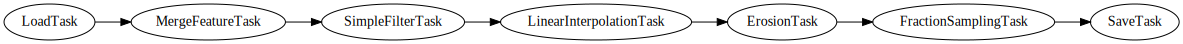

In [ ]:
# Let's visualize it
workflow.dependency_graph()

# **Run the EOWorkflow over all EOPatches**

In [ ]:
%%time

execution_args = []
for idx in range(len(patch_ids)):
    execution_args.append(
        {
            workflow_nodes[0]: {"eopatch_folder": f"eopatch_{idx}"},  # load
            workflow_nodes[-2]: {"seed": 42},                         # sampling
            workflow_nodes[-1]: {"eopatch_folder": f"eopatch_{idx}"}, # save
        }
    )

executor = EOExecutor(workflow, execution_args, save_logs=True)
executor.run(workers=5)

executor.make_report()

failed_ids = executor.get_failed_executions()
if failed_ids:
    raise RuntimeError(
        f"Execution failed EOPatches with IDs:\n{failed_ids}\n"
        f"For more info check report at {executor.get_report_path()}"
    )

DEBUG:eolearn.core.eoworkflow:Computing LoadTask(*[], **{'eopatch_folder': 'eopatch_0'})


  0%|          | 0/25 [00:00<?, ?it/s]

Streaming output truncated to the last 5000 lines.
DEBUG:fiona.crs:Matched. confidence=100, c_code=b'32617', c_name=b'EPSG'
DEBUG:fiona.ogrext:OLC_FASTSETNEXTBYINDEX: 0
DEBUG:fiona.ogrext:OLC_FASTFEATURECOUNT: 1
DEBUG:fiona.ogrext:Next index: 0
DEBUG:fiona.ogrext:Next index: 1
DEBUG:fiona.ogrext:Next index: 2
DEBUG:fiona.ogrext:Next index: 3
DEBUG:fiona.ogrext:Next index: 4
DEBUG:eolearn.core.eoworkflow:Removing intermediate result of LoadTask (node uid: LoadTask-106867377a6711ee809b-8410f0320273)
DEBUG:fiona.ogrext:Next index: 5
DEBUG:eolearn.core.eoworkflow:Computing SimpleFilterTask(*[EOPatch(
  bbox=BBox(((803171.883850342, 33321.94117647059), (809699.6171190492, 38235.17647058824)), crs=CRS('32617'))
  timestamps=[2022-01-01 15:43:06, ...]<length=49>
  mask_timeless={
    LULC: numpy.ndarray(shape=(491, 653, 1), dtype=uint8)
    VALID_COUNT: numpy.ndarray(shape=(491, 653, 1), dtype=int64)
  }
  mask={
    CLM: numpy.ndarray(shape=(49, 491, 653, 1), dtype=uint8)
    IS_DATA: numpy.

RuntimeError: ignored

# **2. Model construction and training**

## 2. Model construction and training

The patches are split into a train and test subset, where we split the patches for training and testing.

The test sample is hand picked because of the small set of patches, otherwise with a larged overall set, the training and testing patches should be randomly chosen.

The sampled features and labels are loaded and reshaped into $n \times m$, where $n$ represents the number of training pixels, and $m = f \times t$ the number of all features (in this example 195), with $f$ the size of bands and band combinations (in this example 9) and $t$ the length of the resampled time-series (in this example 25)

[LightGBM](https://github.com/Microsoft/LightGBM) is used as a ML model. It is a fast, distributed, high performance gradient boosting framework based on decision tree algorithms, used for many machine learning tasks.

The default hyper-parameters are used in this example. For more info on parameter tuning, check the [ReadTheDocs](https://lightgbm.readthedocs.io/en/latest/Parameters-Tuning.html) of the package.

In [56]:
# Load sampled eopatches
sampled_eopatches = []

for i in range(len(patch_ids)):
    sample_path = os.path.join(EOPATCH_SAMPLES_FOLDER, f"eopatch_{i}")
    sampled_eopatches.append(EOPatch.load(sample_path, lazy_loading=True))

In [57]:
# Definition of the train and test patch IDs, take 80 % for train
test_ids = [0, 8, 16, 19, 20]
test_eopatches = [sampled_eopatches[i] for i in test_ids]
train_ids = [i for i in range(len(patch_ids)) if i not in test_ids]
train_eopatches = [sampled_eopatches[i] for i in train_ids]

# Set the features and the labels for train and test sets
features_train = np.concatenate([eopatch.data["FEATURES_SAMPLED"] for eopatch in train_eopatches], axis=1)
labels_train = np.concatenate([eopatch.mask_timeless["LULC_ERODED"] for eopatch in train_eopatches], axis=0)

features_test = np.concatenate([eopatch.data["FEATURES_SAMPLED"] for eopatch in test_eopatches], axis=1)
labels_test = np.concatenate([eopatch.mask_timeless["LULC_ERODED"] for eopatch in test_eopatches], axis=0)

# Get shape
t, w1, h, f = features_train.shape
t, w2, h, f = features_test.shape

# Reshape to n x m
features_train = np.moveaxis(features_train, 0, 2).reshape(w1 * h, t * f)
labels_train = labels_train.reshape(w1 * h)
features_test = np.moveaxis(features_test, 0, 2).reshape(w2 * h, t * f)
labels_test = labels_test.reshape(w2 * h)

In [58]:
features_train.shape

(1603113, 225)

### Set up and train the model

In [59]:
%%time

# Set up training classes
labels_unique = np.unique(labels_train)

# Set up the model
model = lgb.LGBMClassifier(
    objective="multiclass", num_class=len(labels_unique), metric="multi_logloss", random_state=42
)

# Train the model
model.fit(features_train, labels_train)

# Save the model
joblib.dump(model, os.path.join(RESULTS_FOLDER, "Imbabura_model_SI_LULC.pkl"))

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.387589 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 55080
[LightGBM] [Info] Number of data points in the train set: 1603113, number of used features: 216
[LightGBM] [Info] Start training from score -1.581741
[LightGBM] [Info] Start training from score -1.046739
[LightGBM] [Info] Start training from score -1.170328
[LightGBM] [Info] Start training from score -4.475154
[LightGBM] [Info] Start training from score -5.686475
[LightGBM] [Info] Start training from score -10.676540
[LightGBM] [Info] Start training from score -2.135087
CPU times: user 17min 55s, sys: 1.37 s, total: 17min 56s
Wall time: 4min 44s


['/content/drive/MyDrive/AI_LU_LC_Imbabura/results/Imbabura_model_SI_LULC.pkl']

## 3. Validation

Validation of the model is a crucial step in data science. All models are wrong, but some are less wrong than others, so model evaluation is important.

In order to validate the model, we use the training set to predict the classes, and then compare the predicted set of labels to the "ground truth".

Unfortunately, ground truth in the scope of EO is a term that should be taken lightly. Usually, it is not 100 % reliable due to several reasons:

* Labels are determined at specific time, but land use can change (*what was once a field, may now be a house*)
* Labels are overly generalized (*a province is an artificial surface, but it also contains parks, forests etc.*)
* Some classes can have an overlap or similar definitions (*part of a continuum, and not discrete distributions*)
* Human error (*mistakes made when producing the reference map*)

The validation is performed by evaluating various metrics, such as accuracy, precision, recall, $F_1$ score, some of which are nicely described [in this blog post](https://medium.com/greyatom/performance-metrics-for-classification-problems-in-machine-learning-part-i-b085d432082b).

In [60]:
# Load the model
model_path = os.path.join(RESULTS_FOLDER, "Imbabura_model_SI_LULC.pkl")
model = joblib.load(model_path)

# Predict the test labels
predicted_labels_test = model.predict(features_test)

Get the overall accuracy (OA) and the weighted $F_1$ score and the $F_1$ score, precision, and recall for each class separately

In [61]:
class_labels = np.unique(labels_test)
class_names = [lulc_type.name for lulc_type in LULC]
mask = np.in1d(predicted_labels_test, labels_test)
predictions = predicted_labels_test[mask]
true_labels = labels_test[mask]

# Extract and display metrics
f1_scores = metrics.f1_score(true_labels, predictions, labels=class_labels, average=None)
avg_f1_score = metrics.f1_score(true_labels, predictions, average="weighted")
recall = metrics.recall_score(true_labels, predictions, labels=class_labels, average=None)
precision = metrics.precision_score(true_labels, predictions, labels=class_labels, average=None)
accuracy = metrics.accuracy_score(true_labels, predictions)

print("Classification accuracy {:.1f}%".format(100 * accuracy))
print("Classification F1-score {:.1f}%".format(100 * avg_f1_score))
print()
print("             Class              =  F1  | Recall | Precision")
print("         --------------------------------------------------")
for idx, lulctype in enumerate([class_names[idx] for idx in class_labels]):
    line_data = (lulctype, f1_scores[idx] * 100, recall[idx] * 100, precision[idx] * 100)
    print("         * {0:20s} = {1:2.1f} |  {2:2.1f}  | {3:2.1f}".format(*line_data))

Classification accuracy 75.7%
Classification F1-score 76.4%

             Class              =  F1  | Recall | Precision
         --------------------------------------------------
         * CULTIVATED_LAND      = 67.6 |  81.8  | 57.6
         * FOREST               = 84.0 |  78.5  | 90.3
         * GRASSLAND            = 71.6 |  74.9  | 68.6
         * SHRUBLAND            = 2.3 |  4.3  | 1.6
         * WATER                = 62.9 |  46.9  | 95.6
         * WETLAND              = 0.0 |  0.0  | 0.0
         * ARTIFICIAL_SURFACE   = 74.9 |  66.6  | 85.6


### Plot the standard and transposed Confusion Matrix

In [62]:
def plot_confusion_matrix(
    confusion_matrix,
    classes,
    normalize=False,
    title="Confusion matrix",
    cmap=plt.cm.Blues,
    ylabel="True label",
    xlabel="Predicted label",
):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    np.set_printoptions(precision=2, suppress=True)

    if normalize:
        normalisation_factor = confusion_matrix.sum(axis=1)[:, np.newaxis] + np.finfo(float).eps
        confusion_matrix = confusion_matrix.astype("float") / normalisation_factor

    plt.imshow(confusion_matrix, interpolation="nearest", cmap=cmap, vmin=0, vmax=1)
    plt.title(title, fontsize=20)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90, fontsize=20)
    plt.yticks(tick_marks, classes, fontsize=20)

    fmt = ".2f" if normalize else "d"
    threshold = confusion_matrix.max() / 2.0
    for i, j in itertools.product(range(confusion_matrix.shape[0]), range(confusion_matrix.shape[1])):
        plt.text(
            j,
            i,
            format(confusion_matrix[i, j], fmt),
            horizontalalignment="center",
            color="white" if confusion_matrix[i, j] > threshold else "black",
            fontsize=12,
        )

    plt.tight_layout()
    plt.ylabel(ylabel, fontsize=20)
    plt.xlabel(xlabel, fontsize=20)

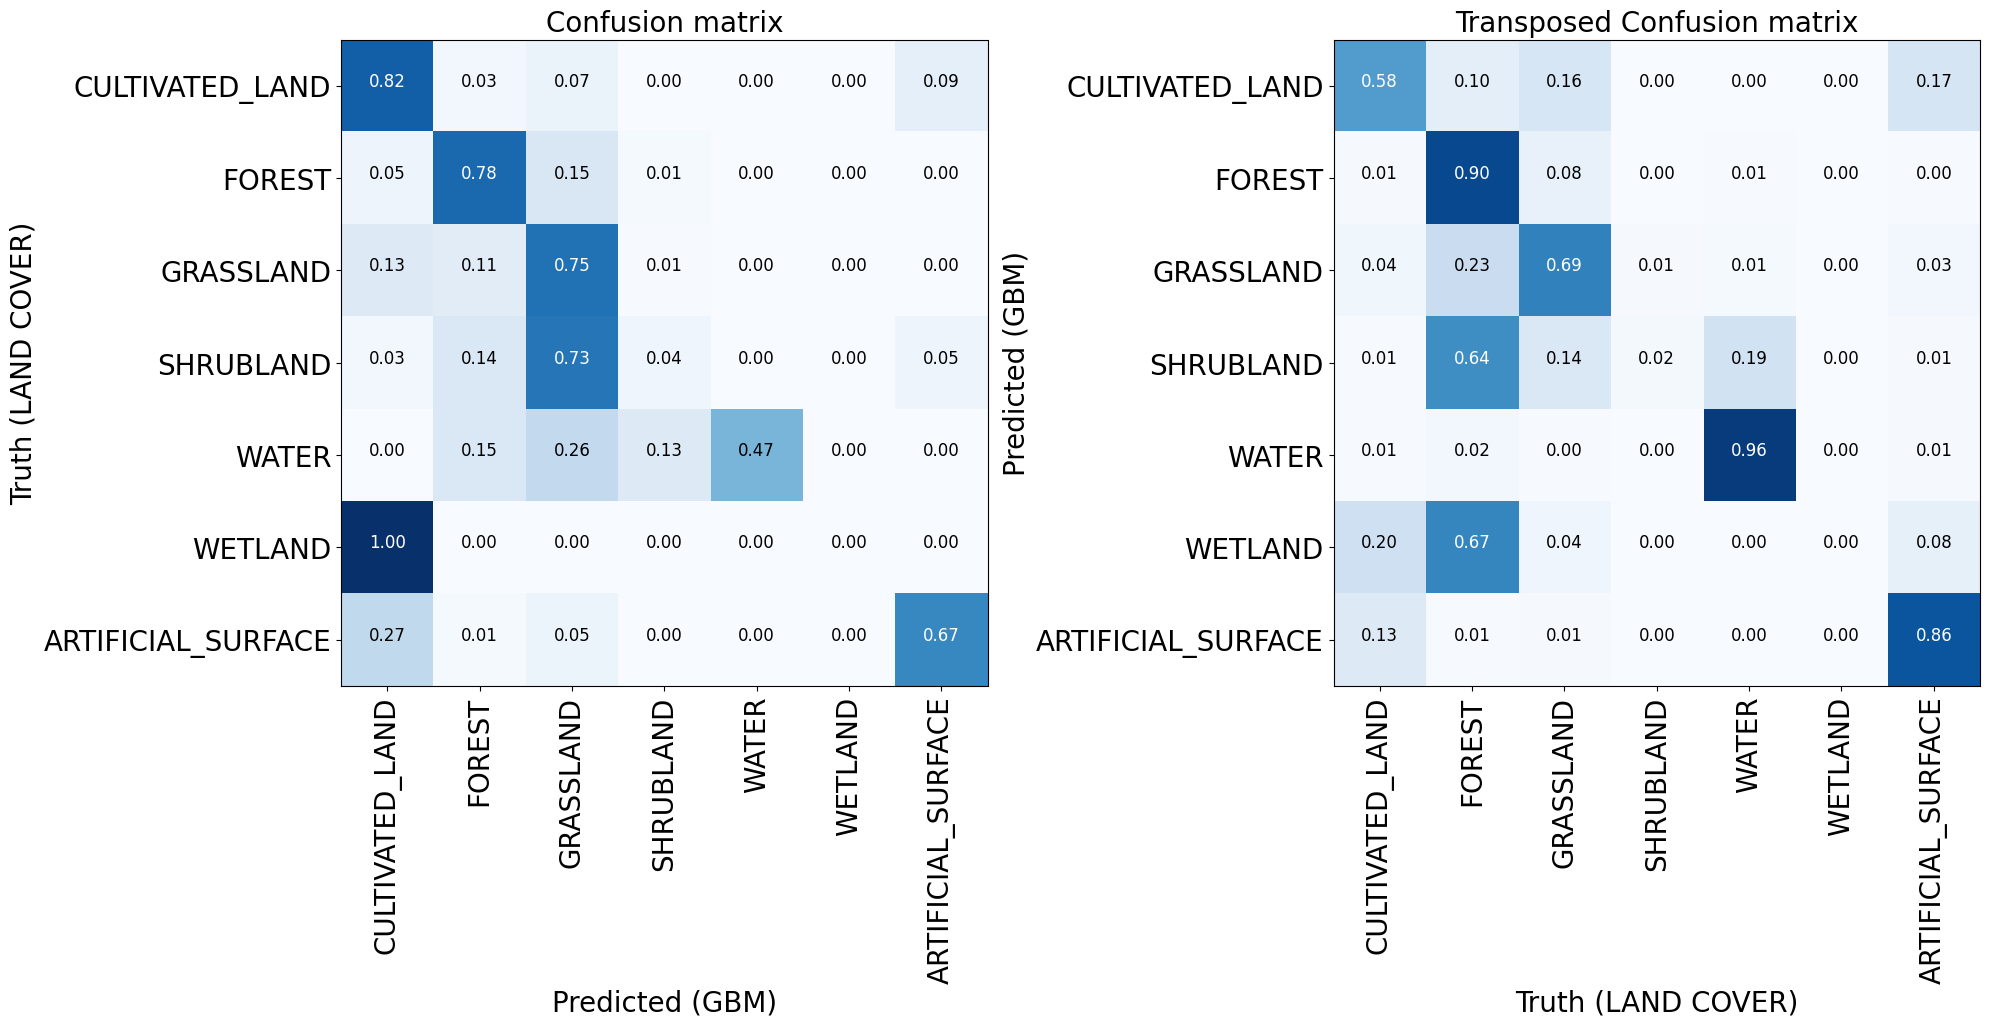

In [63]:
fig = plt.figure(figsize=(20, 20))

plt.subplot(1, 2, 1)
confusion_matrix_gbm = metrics.confusion_matrix(true_labels, predictions)
plot_confusion_matrix(
    confusion_matrix_gbm,
    classes=[name for idx, name in enumerate(class_names) if idx in class_labels],
    normalize=True,
    ylabel="Truth (LAND COVER)",
    xlabel="Predicted (GBM)",
    title="Confusion matrix",
)

plt.subplot(1, 2, 2)
confusion_matrix_gbm = metrics.confusion_matrix(predictions, true_labels)
plot_confusion_matrix(
    confusion_matrix_gbm,
    classes=[name for idx, name in enumerate(class_names) if idx in class_labels],
    normalize=True,
    xlabel="Truth (LAND COVER)",
    ylabel="Predicted (GBM)",
    title="Transposed Confusion matrix",
)

plt.tight_layout()

# save fig
name_file_fig = os.path.join(FIGS_FOLDER, f"Imbabura-Truth-LC-Confusion-Matrix-Transposed.png")
fig.savefig(name_file_fig, bbox_inches="tight")

For most of the classes the model seems to perform well. Otherwise the training sample is probably too small to make a fair assesment.
Additional problems arise due to the unbalanced training set. The image below shows the frequency of the classes used for model training, and we see that the problematic cases are all the under-represented classes: shrubland, water, wetland, and bareland.

Improving the reference map would also affect the end result, as, for example some classes are mixed up to some level.

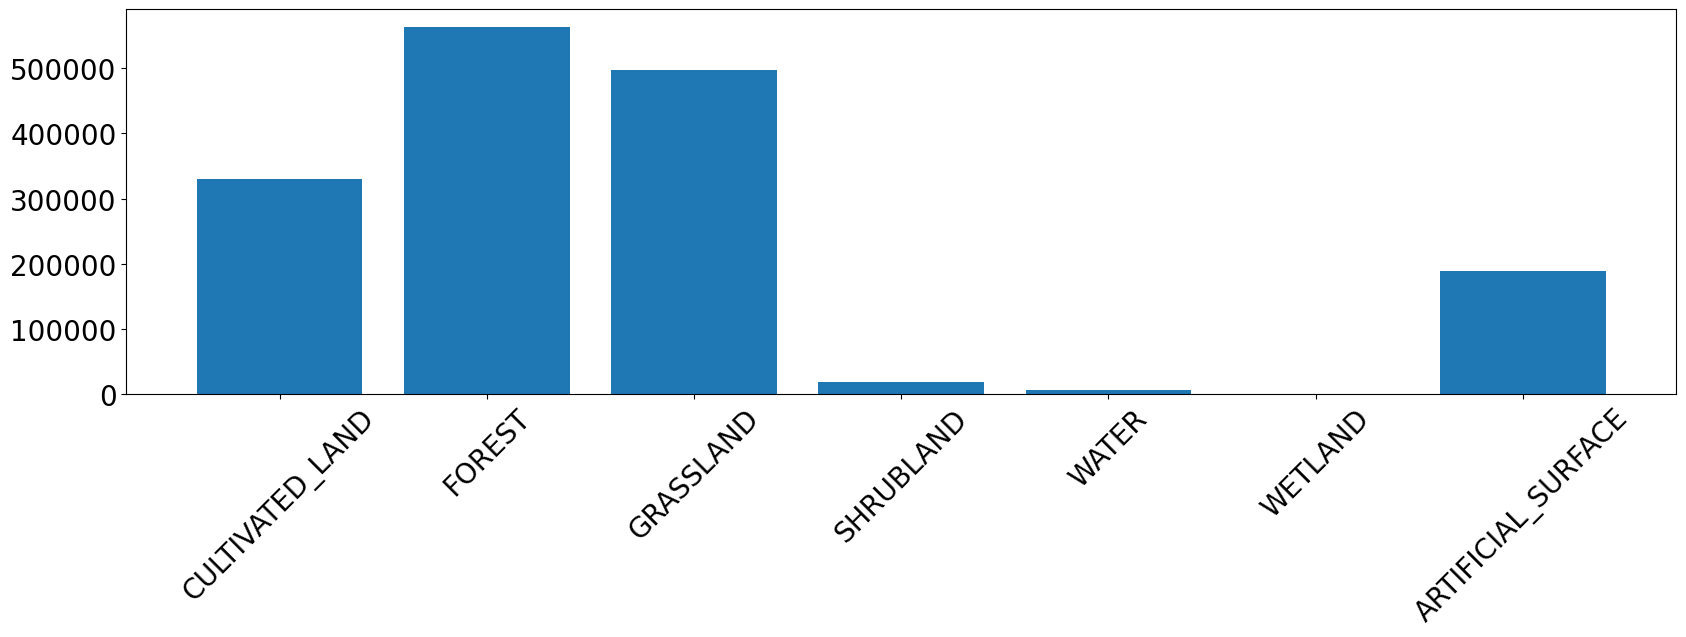

In [64]:
fig = plt.figure(figsize=(20, 5))

label_ids, label_counts = np.unique(labels_train, return_counts=True)

plt.bar(range(len(label_ids)), label_counts)
plt.xticks(range(len(label_ids)), [class_names[i] for i in label_ids], rotation=45, fontsize=20)
plt.yticks(fontsize=20);

# save fig
name_file_fig = os.path.join(FIGS_FOLDER, f"Imbabura_BarCode_Truth_LC_Confusion_Matrix_Transposed.png")
fig.savefig(name_file_fig, bbox_inches="tight")

### ROC curves and AUC metrics

Calculate precision and recall rates, draw ROC curves and calculate AUC.

In [65]:
class_labels = np.unique(np.hstack([labels_test, labels_train]))

scores_test = model.predict_proba(features_test)
labels_binarized = preprocessing.label_binarize(labels_test, classes=class_labels)

fpr, tpr, roc_auc = {}, {}, {}

for idx, _ in enumerate(class_labels):
    fpr[idx], tpr[idx], _ = metrics.roc_curve(labels_binarized[:, idx], scores_test[:, idx])
    roc_auc[idx] = metrics.auc(fpr[idx], tpr[idx])

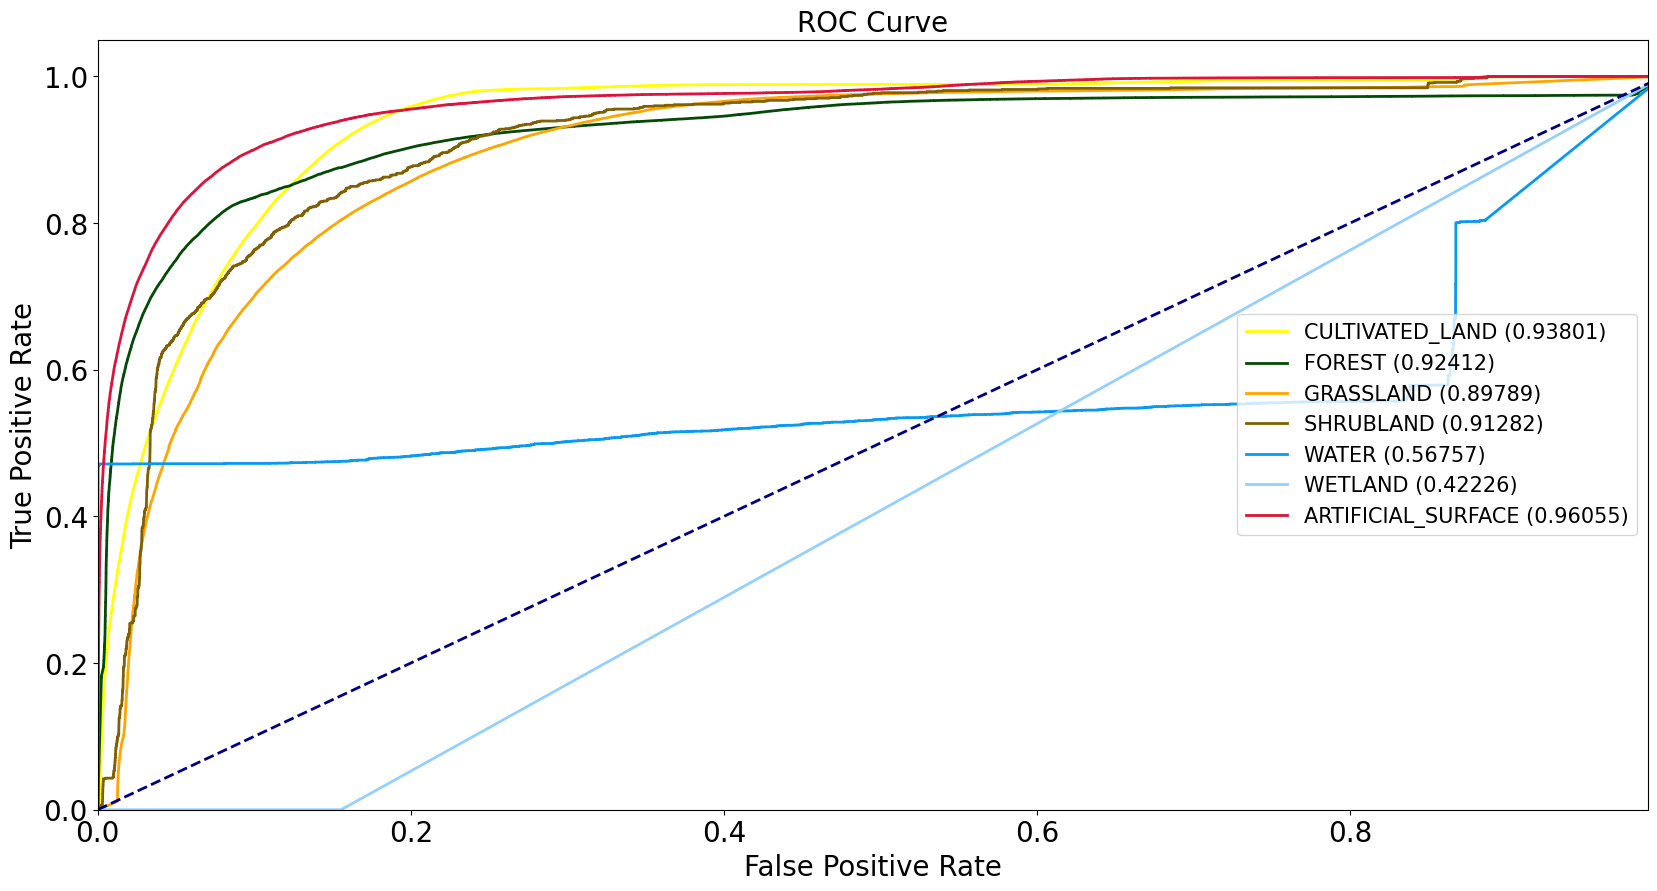

In [66]:
fig = plt.figure(figsize=(20, 10))

for idx, lbl in enumerate(class_labels):
    if np.isnan(roc_auc[idx]):
        continue
    plt.plot(
        fpr[idx],
        tpr[idx],
        color=lulc_cmap.colors[lbl],
        lw=2,
        label=class_names[lbl] + " ({:0.5f})".format(roc_auc[idx]),
    )


plt.plot([0, 1], [0, 1], color="navy", lw=2, linestyle="--")
plt.xlim([0.0, 0.99])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate", fontsize=20)
plt.ylabel("True Positive Rate", fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.title("ROC Curve", fontsize=20)
plt.legend(loc="center right", prop={"size": 15})
plt.show()

# save fig
name_file_fig = os.path.join(FIGS_FOLDER, f"Imbabura_ROC_Curve.png")
fig.savefig(name_file_fig, bbox_inches="tight")

### Most important features

Let us now check which features are most important in the above classification. The LightGBM model already contains the information about feature importances, so we only need to query them.

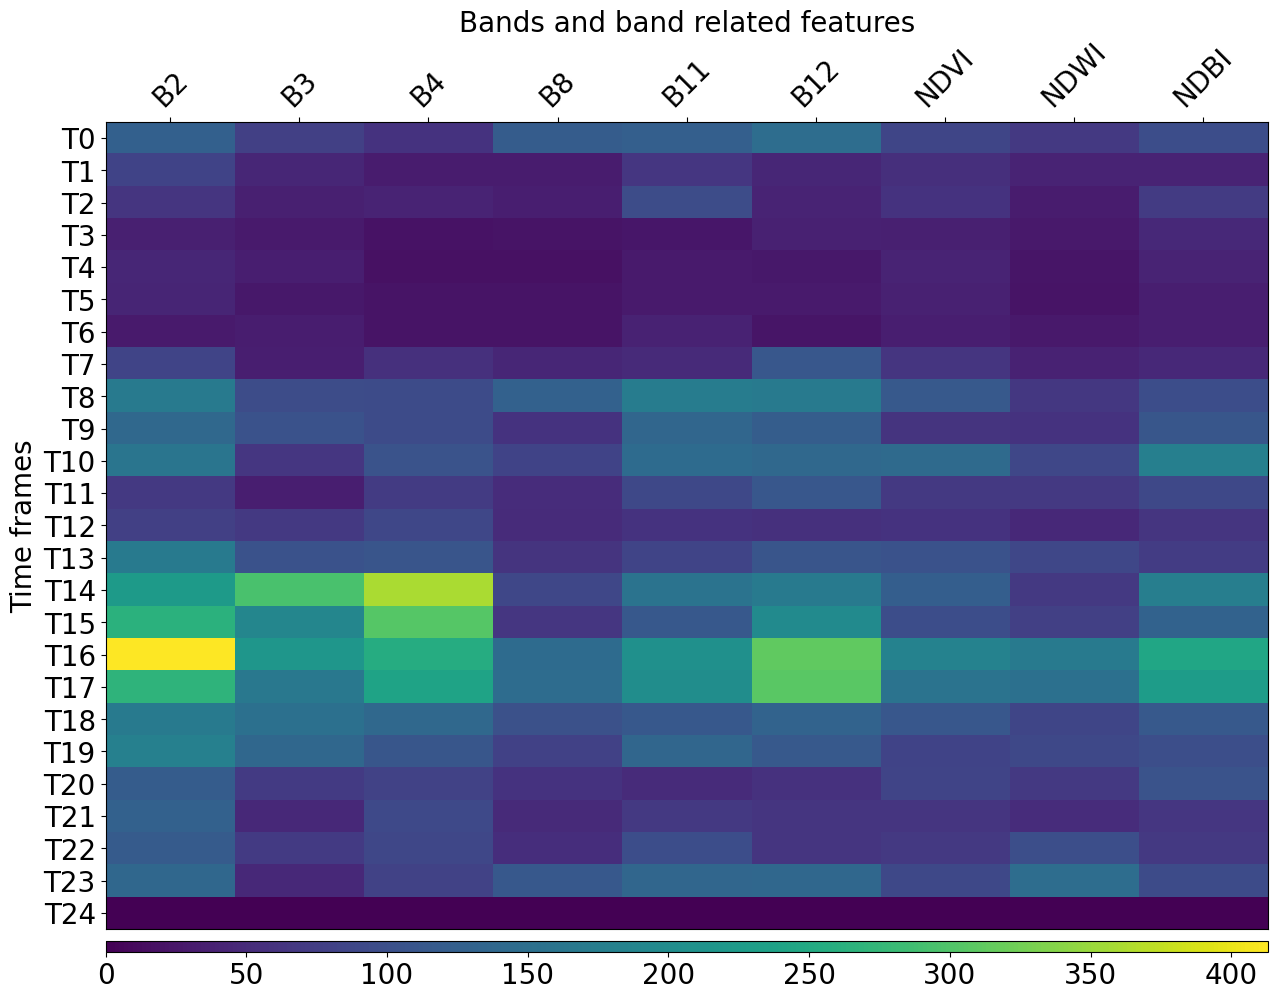

In [67]:
# Feature names
fnames = ["B2", "B3", "B4", "B8", "B11", "B12", "NDVI", "NDWI", "NDBI"]

# Get feature importances and reshape them to dates and features
feature_importances = model.feature_importances_.reshape((t, f))

fig = plt.figure(figsize=(15, 15))
ax = plt.gca()

# Plot the importances
im = ax.imshow(feature_importances, aspect=0.25)
plt.xticks(range(len(fnames)), fnames, rotation=45, fontsize=20)
plt.yticks(range(t), [f"T{i}" for i in range(t)], fontsize=20)
plt.xlabel("Bands and band related features", fontsize=20)
plt.ylabel("Time frames", fontsize=20)
ax.xaxis.tick_top()
ax.xaxis.set_label_position("top")

fig.subplots_adjust(wspace=0, hspace=0)

cb = fig.colorbar(im, ax=[ax], orientation="horizontal", pad=0.01, aspect=100)
cb.ax.tick_params(labelsize=20)

# save fig
name_file_fig = os.path.join(FIGS_FOLDER, f"Imbabura_Bands_and_band_related_features.png")
fig.savefig(name_file_fig, bbox_inches="tight")

In [68]:
# Draw the RGB image
fig, axs = plt.subplots(nrows=5, ncols=5, figsize=(20, 20))

time_id = np.where(feature_importances == np.max(feature_importances))[0][0]

for i in tqdm(range(len(patch_ids))):
    sample_path = os.path.join(EOPATCH_SAMPLES_FOLDER, f"eopatch_{i}")
    eopatch = EOPatch.load(sample_path, lazy_loading=True)
    ax = axs[i // 5][i % 5]
    ax.imshow(np.clip(eopatch.data["FEATURES"][time_id][..., [2, 1, 0]] * 2.5, 0, 1))
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_aspect("auto")
    del eopatch

fig.subplots_adjust(wspace=0, hspace=0)

# save fig
name_file_fig = os.path.join(FIGS_FOLDER, f"Imbabura_RGB_After_Training.png")
fig.savefig(name_file_fig, bbox_inches="tight")

Output hidden; open in https://colab.research.google.com to view.

## 8. Visualization of the results

The model has been validated, the remaining thing is to make the prediction on the whole AOI.

Here we define a workflow to make the model prediction on the existing EOPatces. The EOTask accepts the features and the names for the labels and scores. The latter is optional.

### Define EOTasks

In [69]:
class PredictPatchTask(EOTask):
    """
    Task to make model predictions on a patch. Provide the model and the feature,
    and the output names of labels and scores (optional)
    """

    def __init__(self, model, features_feature, predicted_labels_name, predicted_scores_name=None):
        self.model = model
        self.features_feature = features_feature
        self.predicted_labels_name = predicted_labels_name
        self.predicted_scores_name = predicted_scores_name

    def execute(self, eopatch):
        features = eopatch[self.features_feature]

        t, w, h, f = features.shape
        features = np.moveaxis(features, 0, 2).reshape(w * h, t * f)

        predicted_labels = self.model.predict(features)
        predicted_labels = predicted_labels.reshape(w, h)
        predicted_labels = predicted_labels[..., np.newaxis]
        eopatch[(FeatureType.MASK_TIMELESS, self.predicted_labels_name)] = predicted_labels

        if self.predicted_scores_name:
            predicted_scores = self.model.predict_proba(features)
            _, d = predicted_scores.shape
            predicted_scores = predicted_scores.reshape(w, h, d)
            eopatch[(FeatureType.DATA_TIMELESS, self.predicted_scores_name)] = predicted_scores

        return eopatch

### Define Tasks and the Workflow

In [70]:
# LOAD EXISTING EOPATCHES
load = LoadTask(EOPATCH_SAMPLES_FOLDER)

# PREDICT
predict = PredictPatchTask(model, (FeatureType.DATA, "FEATURES"), "LBL_GBM", "SCR_GBM")

# SAVE
save = SaveTask(EOPATCH_SAMPLES_FOLDER, overwrite_permission=OverwritePermission.OVERWRITE_FEATURES)

# EXPORT TIFF
tiff_location = os.path.join(RESULTS_FOLDER, "predicted_tiff")
os.makedirs(tiff_location, exist_ok=True)
export_tiff = ExportToTiffTask((FeatureType.MASK_TIMELESS, "LBL_GBM"), tiff_location)

workflow_nodes = linearly_connect_tasks(load, predict, export_tiff, save)
workflow = EOWorkflow(workflow_nodes)

### Run the prediction and export to GeoTIFF images

Here we use the `EOExecutor` to run the workflow in parallel.

In [71]:
# Create a list of execution arguments for each patch
execution_args = []
for i in range(len(patch_ids)):
    execution_args.append(
        {
            workflow_nodes[0]: {"eopatch_folder": f"eopatch_{i}"},
            workflow_nodes[2]: {"filename": f"{tiff_location}/prediction_eopatch_{i}.tiff"},
            workflow_nodes[3]: {"eopatch_folder": f"eopatch_{i}"},
        }
    )

# Run the executor
executor = EOExecutor(workflow, execution_args)
executor.run(workers=1, multiprocess=False)
executor.make_report()

failed_ids = executor.get_failed_executions()
if failed_ids:
    raise RuntimeError(
        f"Execution failed EOPatches with IDs:\n{failed_ids}\n"
        f"For more info check report at {executor.get_report_path()}"
    )

  0%|          | 0/25 [00:00<?, ?it/s]

In [72]:
%%time
# Merge tiffs with gdal_merge.py (with compression) using bash command magic
# gdal has to be installed on your computer!
!gdal_merge.py -o results/predicted_tiff/merged_prediction.tiff -co compress=LZW results/predicted_tiff/prediction_eopatch_*

0...10...20...30...40...50...60...70...80...90...100 - done.
CPU times: user 21 ms, sys: 2.03 ms, total: 23 ms
Wall time: 1.61 s


### Visualise the prediction

  0%|          | 0/25 [00:00<?, ?it/s]

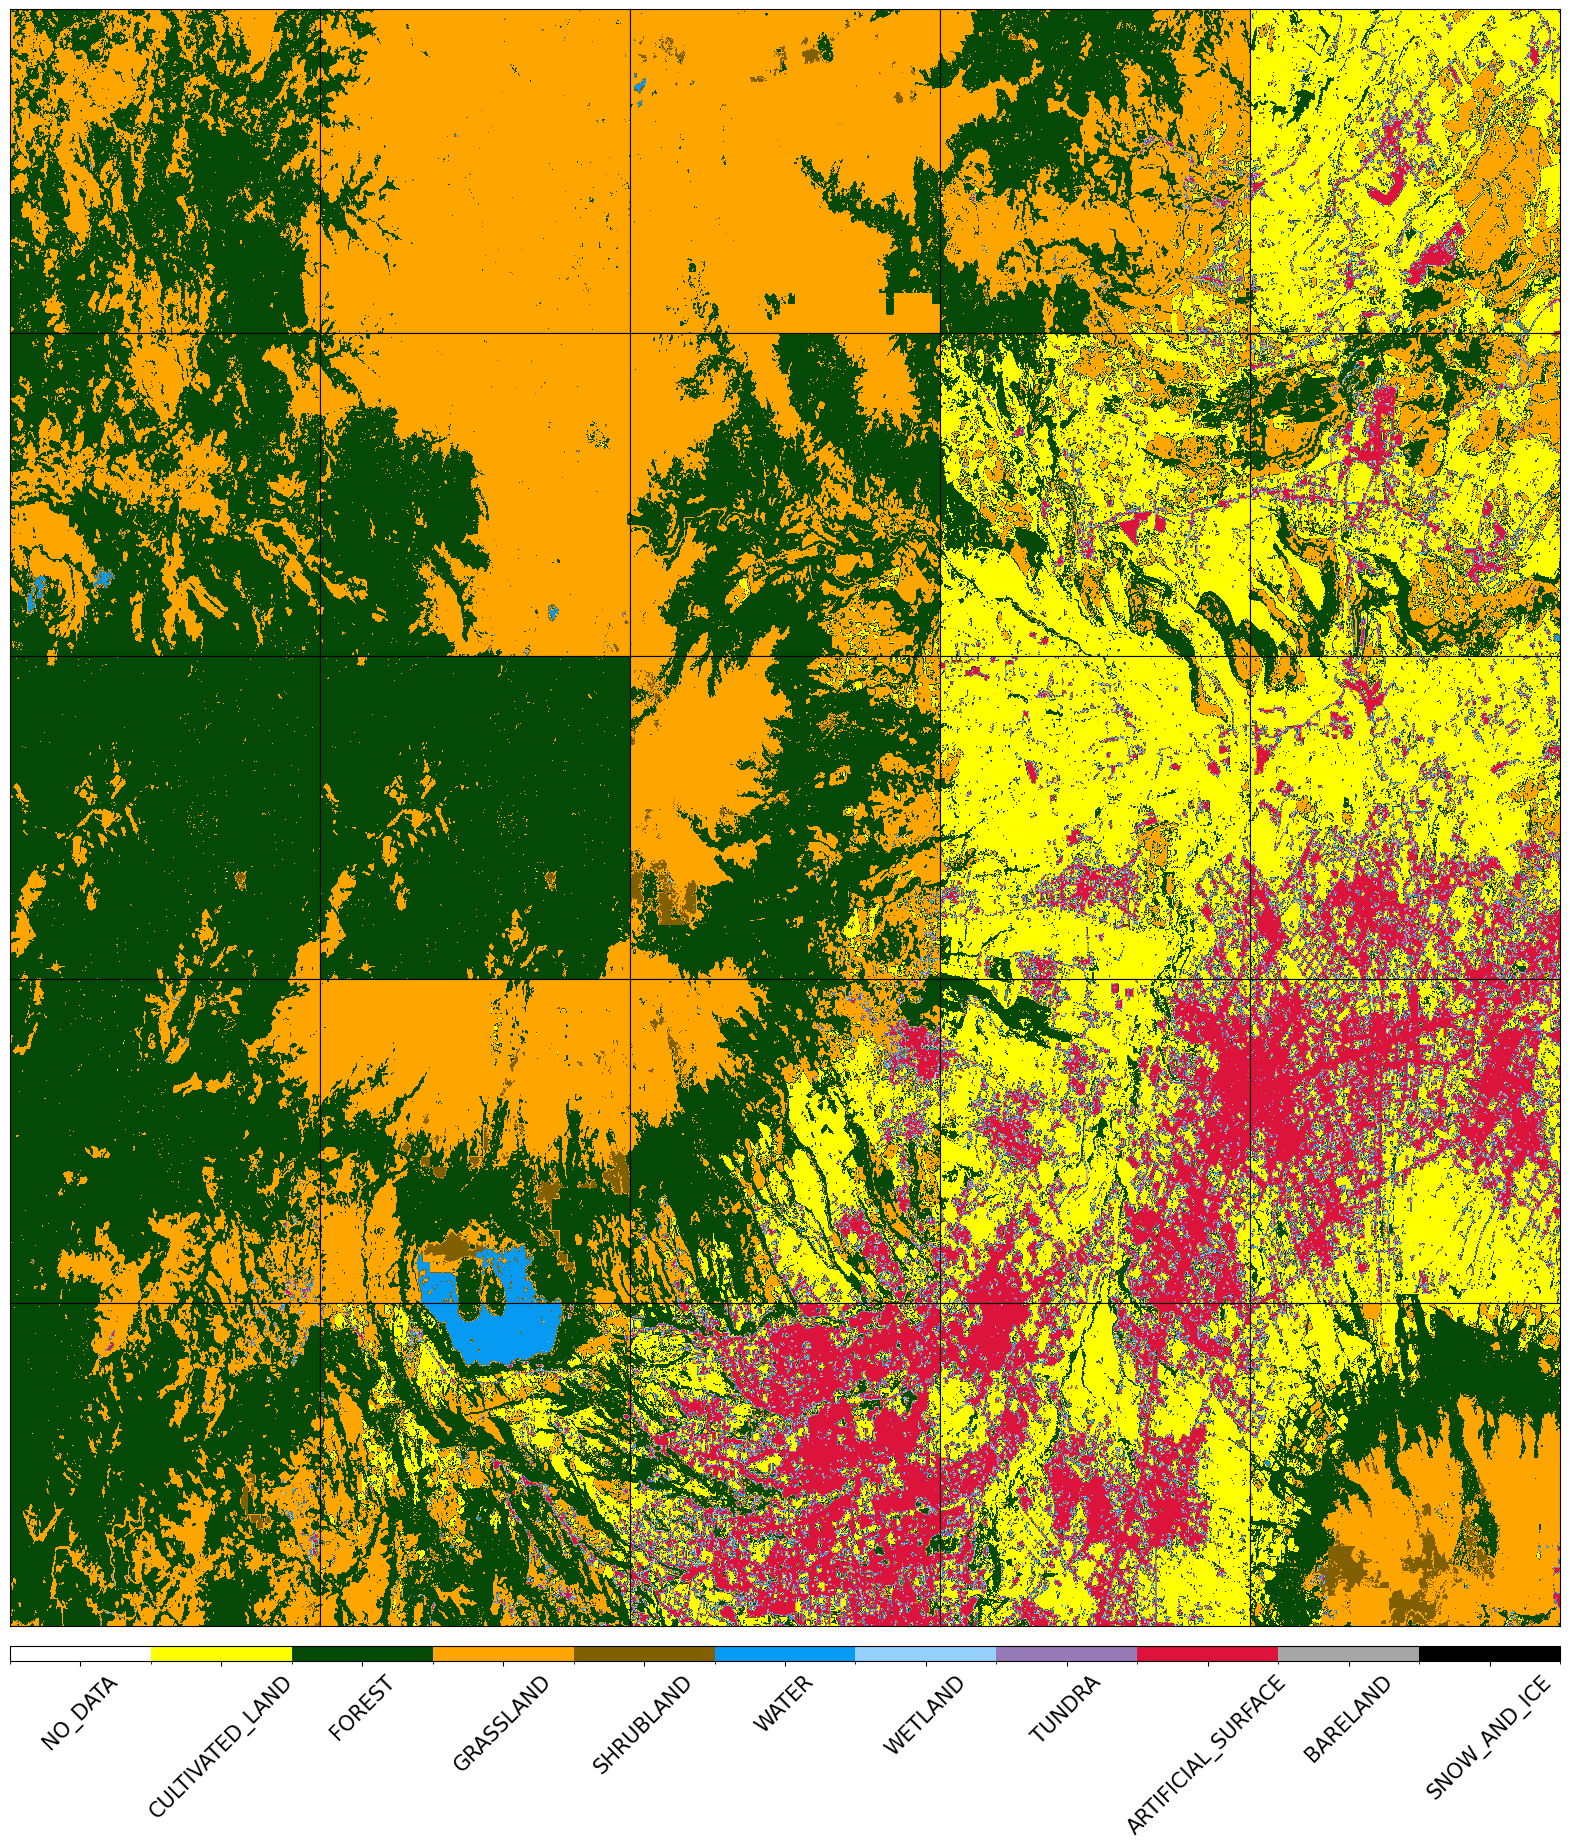

In [73]:
fig, axs = plt.subplots(nrows=5, ncols=5, figsize=(20, 25))

for i in tqdm(range(len(patch_ids))):
    eopatch_path = os.path.join(EOPATCH_SAMPLES_FOLDER, f"eopatch_{i}")
    eopatch = EOPatch.load(eopatch_path, lazy_loading=True)
    ax = axs[i // 5][i % 5]
    im = ax.imshow(eopatch.mask_timeless["LBL_GBM"].squeeze(), cmap=lulc_cmap, norm=lulc_norm)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_aspect("auto")
    del eopatch

fig.subplots_adjust(wspace=0, hspace=0)

cb = fig.colorbar(im, ax=axs.ravel().tolist(), orientation="horizontal", pad=0.01, aspect=100)
cb.ax.tick_params(labelsize=20)
cb.set_ticks([entry.id for entry in LULC])
cb.ax.set_xticklabels([entry.name for entry in LULC], rotation=45, fontsize=15)
plt.show()

# save fig
name_file_fig = os.path.join(FIGS_FOLDER, f"Imbabura_LBL_GBM_After_Training.png")
fig.savefig(name_file_fig, bbox_inches="tight")

### Visual inspection of patches

Here is just a simple piece of code that allows a closer inspection of the predicted labels.

Random subsets of patches are chosen, where prediction and ground truth are compared. For visual aid the mask of differences and the true color image are also provided.

In majority of the cases, differences seem to lie on the border of different structures.

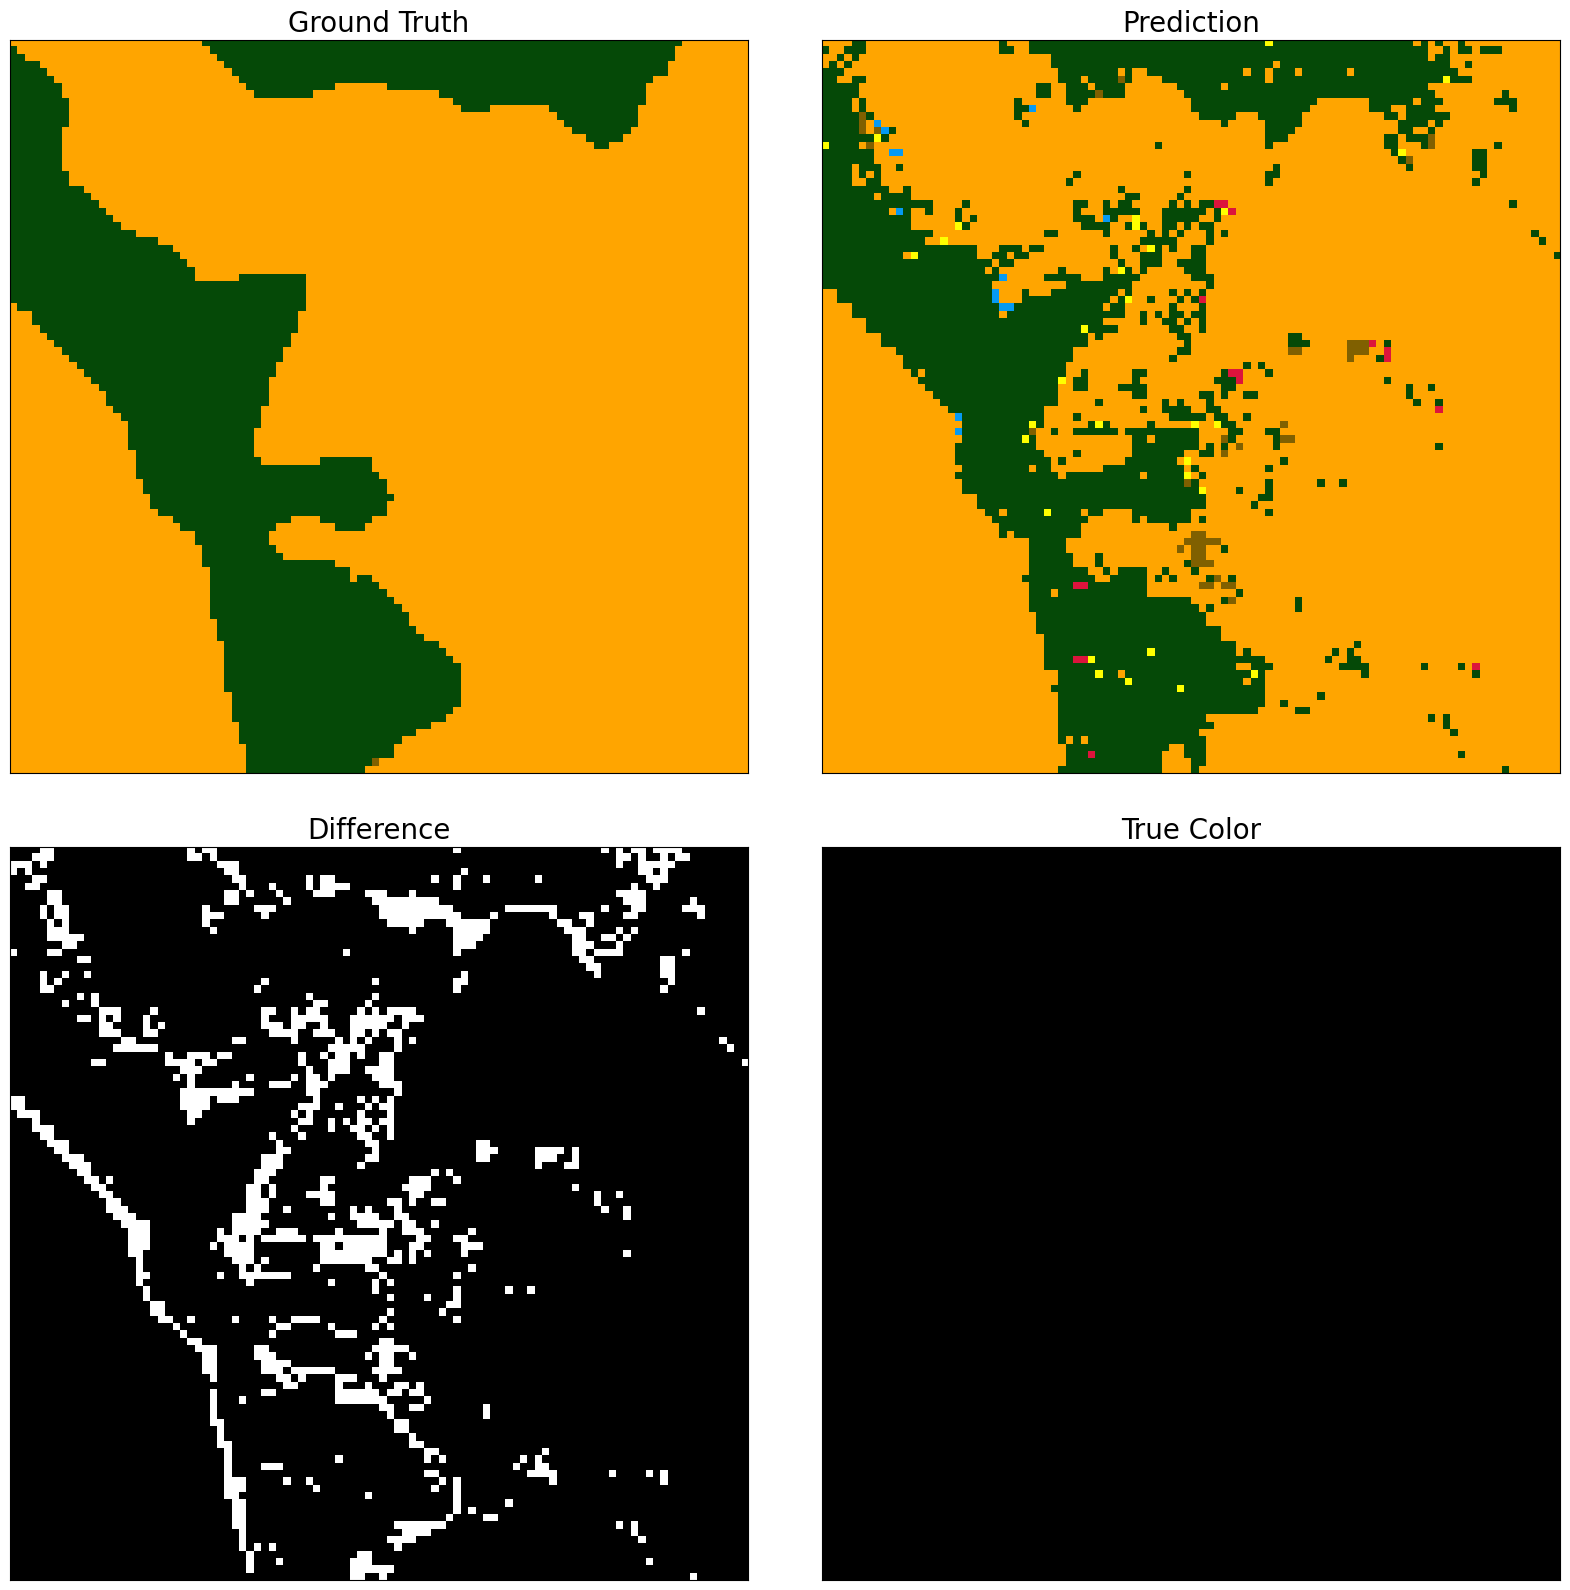

In [74]:
# Draw the Reference map
fig = plt.figure(figsize=(20, 20))

idx = np.random.choice(range(len(patch_ids)))
inspect_size = 100

eopatch = EOPatch.load(os.path.join(EOPATCH_SAMPLES_FOLDER, f"eopatch_{idx}"), lazy_loading=True)

w, h = eopatch.mask_timeless["LULC"].squeeze().shape

w_min = np.random.choice(range(w - inspect_size))
w_max = w_min + inspect_size
h_min = np.random.choice(range(h - inspect_size))
h_max = h_min + inspect_size

ax = plt.subplot(2, 2, 1)
plt.imshow(eopatch.mask_timeless["LULC"].squeeze()[w_min:w_max, h_min:h_max], cmap=lulc_cmap, norm=lulc_norm)
plt.xticks([])
plt.yticks([])
ax.set_aspect("auto")
plt.title("Ground Truth", fontsize=20)

ax = plt.subplot(2, 2, 2)
plt.imshow(eopatch.mask_timeless["LBL_GBM"].squeeze()[w_min:w_max, h_min:h_max], cmap=lulc_cmap, norm=lulc_norm)
plt.xticks([])
plt.yticks([])
ax.set_aspect("auto")
plt.title("Prediction", fontsize=20)

ax = plt.subplot(2, 2, 3)
mask = eopatch.mask_timeless["LBL_GBM"].squeeze() != eopatch.mask_timeless["LULC"].squeeze()
plt.imshow(mask[w_min:w_max, h_min:h_max], cmap="gray")
plt.xticks([])
plt.yticks([])
ax.set_aspect("auto")
plt.title("Difference", fontsize=20)

ax = plt.subplot(2, 2, 4)
image = np.clip(eopatch.data["FEATURES"][8][..., [2, 1, 0]] * 3.5, 0, 1)
plt.imshow(image[w_min:w_max, h_min:h_max])
plt.xticks([])
plt.yticks([])
ax.set_aspect("auto")
plt.title("True Color", fontsize=20)

fig.subplots_adjust(wspace=0.1, hspace=0.1)

# save fig
name_file_fig = os.path.join(FIGS_FOLDER, f"Imbabura_Ground_Truth_Prediction_Difference.png")
fig.savefig(name_file_fig, bbox_inches="tight")